<a href="https://colab.research.google.com/github/gowthaml15/segNetX/blob/main/solar_panel_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision albumentations pillow transformers datasets timm segmentation-models-pytorch tqdm timm

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Drive Connection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data extraction

In [ ]:
path = "/content/drive/MyDrive/solar_panel_detection/PV08.zip"

In [ ]:
import subprocess
subprocess.run(["7z", "x", path, "-ooutput_folder"])

CompletedProcess(args=['7z', 'x', '/content/drive/MyDrive/solar_panel_detection/PV08.zip', '-ooutput_folder'], returncode=0)

In [ ]:
dataset_path = "/content/output_folder/PV08"

In [ ]:
import os
import shutil
import random

In [ ]:
image_dirs = [os.path.join(dataset_path,i) for i in os.listdir(dataset_path)]

In [ ]:
image_dirs

['/content/output_folder/PV08/PV08_Rooftop',
 '/content/output_folder/PV08/PV08_Ground']

In [ ]:
# Define output folders
dataset_base = "/content/dataset"
splits = ["train", "val", "test"]

In [ ]:
# Ensure output directories exist
for split in splits:
    os.makedirs(os.path.join(dataset_base, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(dataset_base, split, "labels"), exist_ok=True)

In [ ]:
# Train-Validation-Test split ratio
train_ratio = 0.7  # 70% training
val_ratio = 0.2    # 20% validation
test_ratio = 0.1   # 10% testing

In [ ]:
# Process each image directory
all_image_label_pairs = []  # Store (image, label) pairs

for img_dir in image_dirs:
    all_images = sorted([f for f in os.listdir(img_dir) if f.endswith('.bmp')])
    # Label directory should be the same as image dir but for labels
    label_dir = img_dir  # Assuming labels are stored in the same directory
    print(label_dir)
    all_labels = sorted([f for f in os.listdir(label_dir) if f.endswith('.bmp') and "_label" in f])
    # Ensure matching image-label pairs
    for img in all_images:
        label_name = img.replace(".bmp", "_label.bmp")  # Match label
        if label_name in all_labels:
            all_image_label_pairs.append((os.path.join(img_dir, img), os.path.join(label_dir, label_name)))

/content/output_folder/PV08/PV08_Rooftop
/content/output_folder/PV08/PV08_Ground


In [ ]:
# Shuffle data
random.shuffle(all_image_label_pairs)

# Split into train, val, and test
total = len(all_image_label_pairs)
train_idx = int(total * train_ratio)
val_idx = train_idx + int(total * val_ratio)

train_set = all_image_label_pairs[:train_idx]
val_set = all_image_label_pairs[train_idx:val_idx]
test_set = all_image_label_pairs[val_idx:]
# Function to move files
def move_files(data_set, subset):
    for img_path, label_path in data_set:
        shutil.copy(img_path, os.path.join(dataset_base, subset, "images", os.path.basename(img_path)))
        shutil.copy(label_path, os.path.join(dataset_base, subset, "labels", os.path.basename(label_path)))

# Move files to respective folders
move_files(train_set, "train")
move_files(val_set, "val")
move_files(test_set, "test")

print("✅ Dataset split completed: Training, Validation, and Testing sets are ready!")

✅ Dataset split completed: Training, Validation, and Testing sets are ready!


## Modules

In [ ]:
import os
import torch
import torchvision.transforms as T
import numpy as np
from transformers import  SwinModel, AutoFeatureExtractor
from torch.utils.data import Dataset, DataLoader
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

import timm

from transformers import SegformerForSemanticSegmentation
from torch.cuda.amp import autocast, GradScaler

## Load dataset & Pre-processing

In [ ]:
# Define Image & Label Preprocessing
# Base Model
transform = A.Compose([
    A.Resize(256, 256),  # Resize images & labels
    A.HorizontalFlip(p=0.5),  # Random flip
    A.RandomBrightnessContrast(p=0.2),  # Random brightness
    A.Normalize(mean=(0.5,), std=(0.5,)),  # Normalize for UNet
    ToTensorV2()
])


class SolarPVDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_filenames = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label_path = os.path.join(self.label_dir, img_name.replace(".bmp", "_label.bmp"))

        # Read image & mask
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)  # RGB image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
        mask = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)  # Read mask in grayscale

        # Apply transformations
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image, mask = transformed["image"], transformed["mask"]
            mask = mask.float()
            mask[mask>0] = 1.0
        return image, mask  # Convert mask to float tensor

# Define dataset paths
train_dataset = SolarPVDataset("/content/dataset/train/images", "/content/dataset/train/labels", transform)
val_dataset = SolarPVDataset("/content/dataset/val/images", "/content/dataset/val/labels", transform)
test_dataset = SolarPVDataset("/content/dataset/test/images", "/content/dataset/test/labels", transform)

## Data Visualization

In [ ]:
train_dataset.__len__(),val_dataset.__len__(),test_dataset.__len__()

(755, 446, 270)

In [ ]:
img, mask = train_dataset.__getitem__(0)

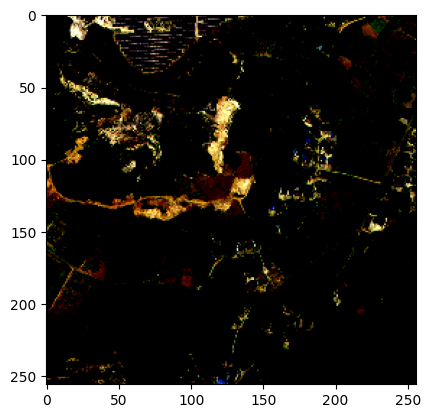

In [ ]:
image_np = img.permute(1,2,0).numpy()
plt.imshow(image_np,cmap='gray')

In [ ]:
mask.unique()

tensor([0., 1.])

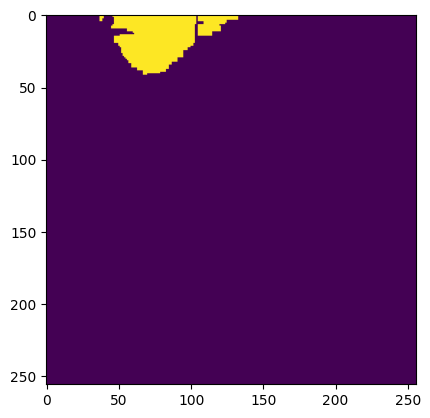

In [ ]:
plt.imshow(mask)

## DataLoader

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

NameError: name 'DataLoader' is not defined

## Enery calculation

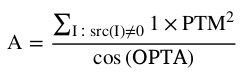

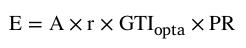

In [ ]:
img, mask = train_dataset.__getitem__(1)

In [ ]:
def compute_solar_area(mask, PTM=0.125, OPTA=34):
    """
    Compute solar panel area from a binary segmentation mask.

    Args:
        mask (torch.Tensor or np.ndarray): Binary mask (1 = panel, 0 = background)
        PTM (float): Pixel-to-Meter Ratio (default = 0.125 m² per pixel)
        OPTA (float): Optimum Tilt Angle (default = 34°)

    Returns:
        float: Estimated solar panel area (m²)
    """
    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().detach().numpy()  # Convert to NumPy if Tensor
    if mask.ndim == 3:
        mask = mask.squeeze(0)  # Remove extra channel

    mask = (mask > 0.5).astype(np.float32)  # Ensure binary mask
    panel_pixels = mask.sum()  # Count solar panel pixels
    area_m2 = (panel_pixels * (PTM ** 2)) / np.cos(np.radians(OPTA))  # Convert to m²
    return area_m2

def compute_accuracy_metrics(segmented_mask, actual_mask, PTM=0.125):
    """
    Compute accuracy of segmented area vs. actual area using MAPE and IoU.

    Args:
        segmented_mask (torch.Tensor or np.ndarray): Predicted segmentation mask.
        actual_mask (torch.Tensor or np.ndarray): Ground truth segmentation mask.
        PTM (float): Pixel-to-Meter Ratio (default = 0.125 m² per pixel).

    Returns:
        dict: Dictionary containing MAPE error and IoU score.
    """
    # Compute solar panel areas
    segmented_area = compute_solar_area(segmented_mask, PTM)
    actual_area = compute_solar_area(actual_mask, PTM)

    # Compute Mean Absolute Percentage Error (MAPE)
    mape_error = np.abs((segmented_area - actual_area) / actual_area) * 100 if actual_area != 0 else 0

    # Compute Intersection over Union (IoU)
    intersection = ((segmented_mask > 0.5) & (actual_mask > 0.5)).sum()
    union = ((segmented_mask > 0.5) | (actual_mask > 0.5)).sum()
    iou_score = intersection / union if union != 0 else 0

    return {
        "Segmented Area (m²)": segmented_area,
        "Actual Area (m²)": actual_area,
        "MAPE (%)": mape_error,
        "IoU Score": iou_score
    }
compute_accuracy_metrics(mask,mask)

{'Segmented Area (m²)': 4.862566104906369,
 'Actual Area (m²)': 4.862566104906369,
 'MAPE (%)': 0.0,
 'IoU Score': tensor(1.)}

In [ ]:
area = compute_solar_area(mask)

In [ ]:
def compute_energy_output(area_m2, efficiency=0.19, GTI=1676.2, PR=0.935):
    """
    Compute estimated solar energy output.

    Args:
        area_m2 (float): Solar panel area in m²
        efficiency (float): Solar panel efficiency (default = 19%)
        GTI (float): Global Tilted Irradiation in kWh/m² (default = 1676.2 kWh/m²) -> Seoul (korea)
        PR (float): Performance Ratio (default = 93.5%)

    Returns:
        float: Estimated energy output (kWh per year)
    """
    return area_m2 * efficiency * GTI * PR

1447.9600066410767
Estimated Solar Panel Area: 4.86 m²
Estimated Energy Output: 1447.96 kWh per year


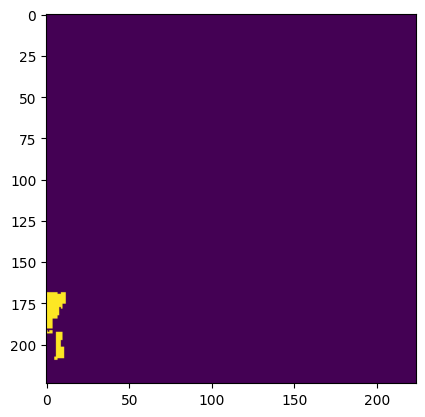

In [ ]:
print(compute_energy_output(area))
# Compute area in m²
area_m2 = compute_solar_area(mask)
print(f"Estimated Solar Panel Area: {area_m2:.2f} m²")

# Compute energy output in kWh
energy_kwh = compute_energy_output(area_m2)
print(f"Estimated Energy Output: {energy_kwh:.2f} kWh per year")
plt.imshow(mask)

# Base Model - Unet with efficientnet-b7

## Model Loading

In [ ]:
# Define UNet Model with a Pre-Trained Encoder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = smp.Unet(
    # encoder_name="resnet34",  # Pretrained backbone (ResNet34)
    encoder_name="efficientnet-b7",  # Pretrained backbone (ResNet34)
    encoder_weights="imagenet",  # Use ImageNet pre-trained weights
    in_channels=3,  # RGB input
    classes=1,  # Single-channel output (Binary Segmentation)
    activation=None  # No activation, use BCEWithLogitsLoss
).to(device)

print("✅ UNet Model Loaded with efficientnet-b7 Backbone")

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:08<00:00, 32.6MB/s]


✅ UNet Model Loaded with efficientnet-b7 Backbone


## Loss Function

In [ ]:
import torch.nn as nn

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = torch.sigmoid(preds)  # Apply Sigmoid
        preds = preds.view(-1)  # Flatten
        targets = targets.view(-1)  # Flatten

        intersection = (preds * targets).sum()
        dice = (2. * intersection + self.smooth) / (preds.sum() + targets.sum() + self.smooth)

        return 1 - dice  # Dice Loss (1 - Dice Coefficient)

## Accuracy Metrics

In [ ]:
# Compute Dice Score
def dice_score(preds, targets, smooth=1e-6):
    preds = torch.sigmoid(preds)  # Convert logits to probabilities
    preds = (preds > 0.5).float()  # Convert to binary mask
    targets = targets.float()

    intersection = (preds * targets).sum()
    dice = (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)

    return dice.item()

# Compute IoU (Jaccard Index)
def iou_score(preds, targets, smooth=1e-6):
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()
    targets = targets.float()

    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    iou = (intersection + smooth) / (union + smooth)

    return iou.item()

# Compute Pixel Accuracy
def pixel_accuracy(preds, targets):
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()

    correct = (preds == targets).sum().item()
    total = targets.numel()

    return correct / total  # Return accuracy percentage

## Defining Parameters

In [ ]:
# Loss function (Binary Segmentation)
# criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy with Logits
# Use Dice Loss instead of BCE Loss
criterion = DiceLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

NameError: name 'model' is not defined

## Training Loop

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device="cuda"):
    model.to(device)

    # Lists to store metrics
    train_losses, val_losses = [], []
    dice_scores, iou_scores, acc_scores = [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # Training Progress Bar
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

        for images, masks in train_loader_tqdm:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, masks.unsqueeze(1))  # Compute loss
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Compute Training Loss
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Compute Validation Metrics
        model.eval()
        total_loss, total_dice, total_iou, total_acc = 0.0, 0.0, 0.0, 0.0
        num_samples = 0

        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)

                loss = criterion(outputs, masks.unsqueeze(1))  # Compute validation loss
                total_loss += loss.item()

                total_dice += dice_score(outputs, masks.unsqueeze(1))
                total_iou += iou_score(outputs, masks.unsqueeze(1))
                total_acc += pixel_accuracy(outputs, masks.unsqueeze(1))

                num_samples += 1

        avg_val_loss = total_loss / num_samples
        avg_dice = total_dice / num_samples
        avg_iou = total_iou / num_samples
        avg_acc = total_acc / num_samples

        # Store validation metrics
        val_losses.append(avg_val_loss)
        dice_scores.append(avg_dice)
        iou_scores.append(avg_iou)
        acc_scores.append(avg_acc)

        print(f"✅ Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Dice: {avg_dice:.4f} | IoU: {avg_iou:.4f} | Acc: {avg_acc:.4f}")

    print("🎯 Training Complete!")

    # Return stored metrics
    return train_losses, val_losses, dice_scores, iou_scores, acc_scores
train_losses, val_losses, dice_scores, iou_scores, acc_scores = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=200, device="cuda"
)

✅ Epoch [1/200] | Train Loss: 0.7030 | Val Loss: 0.6720 | Dice: 0.5816 | IoU: 0.4227 | Acc: 0.8539


✅ Epoch [2/200] | Train Loss: 0.5896 | Val Loss: 0.6029 | Dice: 0.6928 | IoU: 0.5395 | Acc: 0.9047


✅ Epoch [3/200] | Train Loss: 0.5160 | Val Loss: 0.5458 | Dice: 0.8066 | IoU: 0.6834 | Acc: 0.9500


✅ Epoch [4/200] | Train Loss: 0.4416 | Val Loss: 0.4682 | Dice: 0.8451 | IoU: 0.7357 | Acc: 0.9618


✅ Epoch [5/200] | Train Loss: 0.3858 | Val Loss: 0.4037 | Dice: 0.8455 | IoU: 0.7363 | Acc: 0.9606


✅ Epoch [6/200] | Train Loss: 0.3238 | Val Loss: 0.3387 | Dice: 0.8674 | IoU: 0.7686 | Acc: 0.9680


✅ Epoch [7/200] | Train Loss: 0.2666 | Val Loss: 0.2919 | Dice: 0.8756 | IoU: 0.7815 | Acc: 0.9706


✅ Epoch [8/200] | Train Loss: 0.2309 | Val Loss: 0.2588 | Dice: 0.8812 | IoU: 0.7906 | Acc: 0.9728


✅ Epoch [9/200] | Train Loss: 0.2050 | Val Loss: 0.2311 | Dice: 0.8818 | IoU: 0.7921 | Acc: 0.9724


✅ Epoch [10/200] | Train Loss: 0.1815 | Val Loss: 0.2166 | Dice: 0.8858 | IoU: 0.7979 | Acc: 0.9737


✅ Epoch [11/200] | Train Loss: 0.1600 | Val Loss: 0.1934 | Dice: 0.8951 | IoU: 0.8124 | Acc: 0.9752


✅ Epoch [12/200] | Train Loss: 0.1431 | Val Loss: 0.1886 | Dice: 0.8878 | IoU: 0.8009 | Acc: 0.9740


✅ Epoch [13/200] | Train Loss: 0.1294 | Val Loss: 0.1724 | Dice: 0.8924 | IoU: 0.8084 | Acc: 0.9757


✅ Epoch [14/200] | Train Loss: 0.1227 | Val Loss: 0.1610 | Dice: 0.8946 | IoU: 0.8111 | Acc: 0.9753


✅ Epoch [15/200] | Train Loss: 0.1190 | Val Loss: 0.1541 | Dice: 0.8980 | IoU: 0.8167 | Acc: 0.9758


✅ Epoch [16/200] | Train Loss: 0.1060 | Val Loss: 0.1495 | Dice: 0.8961 | IoU: 0.8144 | Acc: 0.9766


✅ Epoch [17/200] | Train Loss: 0.0961 | Val Loss: 0.1423 | Dice: 0.9008 | IoU: 0.8217 | Acc: 0.9770


✅ Epoch [18/200] | Train Loss: 0.0972 | Val Loss: 0.1387 | Dice: 0.9020 | IoU: 0.8233 | Acc: 0.9773


✅ Epoch [19/200] | Train Loss: 0.0885 | Val Loss: 0.1342 | Dice: 0.9006 | IoU: 0.8214 | Acc: 0.9775


✅ Epoch [20/200] | Train Loss: 0.0815 | Val Loss: 0.1357 | Dice: 0.8959 | IoU: 0.8141 | Acc: 0.9762


✅ Epoch [21/200] | Train Loss: 0.0944 | Val Loss: 0.1301 | Dice: 0.8998 | IoU: 0.8201 | Acc: 0.9772


✅ Epoch [22/200] | Train Loss: 0.0818 | Val Loss: 0.1314 | Dice: 0.8975 | IoU: 0.8164 | Acc: 0.9768


✅ Epoch [23/200] | Train Loss: 0.0828 | Val Loss: 0.1216 | Dice: 0.9042 | IoU: 0.8274 | Acc: 0.9784


✅ Epoch [24/200] | Train Loss: 0.0749 | Val Loss: 0.1160 | Dice: 0.9073 | IoU: 0.8322 | Acc: 0.9778


✅ Epoch [25/200] | Train Loss: 0.0716 | Val Loss: 0.1187 | Dice: 0.9025 | IoU: 0.8251 | Acc: 0.9782


✅ Epoch [26/200] | Train Loss: 0.0704 | Val Loss: 0.1080 | Dice: 0.9121 | IoU: 0.8399 | Acc: 0.9791


✅ Epoch [27/200] | Train Loss: 0.0692 | Val Loss: 0.1149 | Dice: 0.9026 | IoU: 0.8255 | Acc: 0.9782


✅ Epoch [28/200] | Train Loss: 0.0666 | Val Loss: 0.1053 | Dice: 0.9107 | IoU: 0.8375 | Acc: 0.9784


✅ Epoch [29/200] | Train Loss: 0.0632 | Val Loss: 0.1039 | Dice: 0.9138 | IoU: 0.8427 | Acc: 0.9795


✅ Epoch [30/200] | Train Loss: 0.0624 | Val Loss: 0.1062 | Dice: 0.9102 | IoU: 0.8366 | Acc: 0.9783


✅ Epoch [31/200] | Train Loss: 0.0598 | Val Loss: 0.1027 | Dice: 0.9118 | IoU: 0.8394 | Acc: 0.9791


✅ Epoch [32/200] | Train Loss: 0.0603 | Val Loss: 0.0984 | Dice: 0.9158 | IoU: 0.8459 | Acc: 0.9795


✅ Epoch [33/200] | Train Loss: 0.0572 | Val Loss: 0.1008 | Dice: 0.9123 | IoU: 0.8401 | Acc: 0.9793


✅ Epoch [34/200] | Train Loss: 0.0618 | Val Loss: 0.0985 | Dice: 0.9142 | IoU: 0.8435 | Acc: 0.9796


✅ Epoch [35/200] | Train Loss: 0.0574 | Val Loss: 0.1040 | Dice: 0.9088 | IoU: 0.8345 | Acc: 0.9787


✅ Epoch [36/200] | Train Loss: 0.0553 | Val Loss: 0.0987 | Dice: 0.9126 | IoU: 0.8408 | Acc: 0.9795


✅ Epoch [37/200] | Train Loss: 0.0557 | Val Loss: 0.0958 | Dice: 0.9144 | IoU: 0.8438 | Acc: 0.9797


✅ Epoch [38/200] | Train Loss: 0.0526 | Val Loss: 0.1000 | Dice: 0.9110 | IoU: 0.8389 | Acc: 0.9799


✅ Epoch [39/200] | Train Loss: 0.0525 | Val Loss: 0.1031 | Dice: 0.9065 | IoU: 0.8315 | Acc: 0.9785


✅ Epoch [40/200] | Train Loss: 0.0525 | Val Loss: 0.1001 | Dice: 0.9088 | IoU: 0.8353 | Acc: 0.9792


✅ Epoch [41/200] | Train Loss: 0.0487 | Val Loss: 0.0971 | Dice: 0.9116 | IoU: 0.8395 | Acc: 0.9795


✅ Epoch [42/200] | Train Loss: 0.0525 | Val Loss: 0.0959 | Dice: 0.9129 | IoU: 0.8414 | Acc: 0.9795


✅ Epoch [43/200] | Train Loss: 0.0540 | Val Loss: 0.0981 | Dice: 0.9100 | IoU: 0.8365 | Acc: 0.9782


✅ Epoch [44/200] | Train Loss: 0.0500 | Val Loss: 0.0934 | Dice: 0.9147 | IoU: 0.8445 | Acc: 0.9798


✅ Epoch [45/200] | Train Loss: 0.0489 | Val Loss: 0.0952 | Dice: 0.9122 | IoU: 0.8402 | Acc: 0.9790


✅ Epoch [46/200] | Train Loss: 0.0496 | Val Loss: 0.0947 | Dice: 0.9124 | IoU: 0.8405 | Acc: 0.9791


✅ Epoch [47/200] | Train Loss: 0.0475 | Val Loss: 0.0922 | Dice: 0.9147 | IoU: 0.8446 | Acc: 0.9799


✅ Epoch [48/200] | Train Loss: 0.0472 | Val Loss: 0.0918 | Dice: 0.9145 | IoU: 0.8443 | Acc: 0.9800


✅ Epoch [49/200] | Train Loss: 0.0445 | Val Loss: 0.0927 | Dice: 0.9138 | IoU: 0.8430 | Acc: 0.9799


✅ Epoch [50/200] | Train Loss: 0.0436 | Val Loss: 0.0895 | Dice: 0.9168 | IoU: 0.8480 | Acc: 0.9802


✅ Epoch [51/200] | Train Loss: 0.0429 | Val Loss: 0.0946 | Dice: 0.9112 | IoU: 0.8388 | Acc: 0.9795


✅ Epoch [52/200] | Train Loss: 0.0442 | Val Loss: 0.0943 | Dice: 0.9116 | IoU: 0.8395 | Acc: 0.9797


✅ Epoch [53/200] | Train Loss: 0.0456 | Val Loss: 0.0865 | Dice: 0.9192 | IoU: 0.8521 | Acc: 0.9810


✅ Epoch [54/200] | Train Loss: 0.0456 | Val Loss: 0.0960 | Dice: 0.9094 | IoU: 0.8354 | Acc: 0.9788


✅ Epoch [55/200] | Train Loss: 0.0434 | Val Loss: 0.0899 | Dice: 0.9154 | IoU: 0.8453 | Acc: 0.9798


✅ Epoch [56/200] | Train Loss: 0.0415 | Val Loss: 0.0897 | Dice: 0.9158 | IoU: 0.8460 | Acc: 0.9798


✅ Epoch [57/200] | Train Loss: 0.0417 | Val Loss: 0.0830 | Dice: 0.9219 | IoU: 0.8564 | Acc: 0.9810


✅ Epoch [58/200] | Train Loss: 0.0426 | Val Loss: 0.0931 | Dice: 0.9118 | IoU: 0.8392 | Acc: 0.9790


✅ Epoch [59/200] | Train Loss: 0.0417 | Val Loss: 0.0885 | Dice: 0.9165 | IoU: 0.8474 | Acc: 0.9806


✅ Epoch [60/200] | Train Loss: 0.0411 | Val Loss: 0.0861 | Dice: 0.9181 | IoU: 0.8500 | Acc: 0.9803


✅ Epoch [61/200] | Train Loss: 0.0398 | Val Loss: 0.0902 | Dice: 0.9143 | IoU: 0.8440 | Acc: 0.9800


✅ Epoch [62/200] | Train Loss: 0.0401 | Val Loss: 0.0988 | Dice: 0.9052 | IoU: 0.8290 | Acc: 0.9780


✅ Epoch [63/200] | Train Loss: 0.0394 | Val Loss: 0.0957 | Dice: 0.9084 | IoU: 0.8346 | Acc: 0.9793


✅ Epoch [64/200] | Train Loss: 0.0418 | Val Loss: 0.0919 | Dice: 0.9119 | IoU: 0.8404 | Acc: 0.9796


✅ Epoch [65/200] | Train Loss: 0.0373 | Val Loss: 0.0918 | Dice: 0.9123 | IoU: 0.8412 | Acc: 0.9799


✅ Epoch [66/200] | Train Loss: 0.0373 | Val Loss: 0.0872 | Dice: 0.9166 | IoU: 0.8478 | Acc: 0.9802


✅ Epoch [67/200] | Train Loss: 0.0373 | Val Loss: 0.1059 | Dice: 0.8976 | IoU: 0.8184 | Acc: 0.9762


✅ Epoch [68/200] | Train Loss: 0.0372 | Val Loss: 0.0945 | Dice: 0.9088 | IoU: 0.8353 | Acc: 0.9790


✅ Epoch [69/200] | Train Loss: 0.0366 | Val Loss: 0.0950 | Dice: 0.9083 | IoU: 0.8344 | Acc: 0.9792


✅ Epoch [70/200] | Train Loss: 0.0364 | Val Loss: 0.1008 | Dice: 0.9027 | IoU: 0.8254 | Acc: 0.9782


✅ Epoch [71/200] | Train Loss: 0.0372 | Val Loss: 0.0915 | Dice: 0.9118 | IoU: 0.8398 | Acc: 0.9796


✅ Epoch [72/200] | Train Loss: 0.0357 | Val Loss: 0.0894 | Dice: 0.9136 | IoU: 0.8429 | Acc: 0.9798


✅ Epoch [73/200] | Train Loss: 0.0368 | Val Loss: 0.0978 | Dice: 0.9053 | IoU: 0.8296 | Acc: 0.9778


✅ Epoch [74/200] | Train Loss: 0.0371 | Val Loss: 0.0904 | Dice: 0.9127 | IoU: 0.8414 | Acc: 0.9796


✅ Epoch [75/200] | Train Loss: 0.0360 | Val Loss: 0.0910 | Dice: 0.9121 | IoU: 0.8403 | Acc: 0.9790


✅ Epoch [76/200] | Train Loss: 0.0379 | Val Loss: 0.0889 | Dice: 0.9141 | IoU: 0.8441 | Acc: 0.9799


✅ Epoch [77/200] | Train Loss: 0.0364 | Val Loss: 0.0929 | Dice: 0.9102 | IoU: 0.8371 | Acc: 0.9782


✅ Epoch [78/200] | Train Loss: 0.0366 | Val Loss: 0.0870 | Dice: 0.9157 | IoU: 0.8463 | Acc: 0.9802


✅ Epoch [79/200] | Train Loss: 0.0366 | Val Loss: 0.1024 | Dice: 0.9000 | IoU: 0.8212 | Acc: 0.9772


✅ Epoch [80/200] | Train Loss: 0.0347 | Val Loss: 0.0823 | Dice: 0.9204 | IoU: 0.8540 | Acc: 0.9808


✅ Epoch [81/200] | Train Loss: 0.0333 | Val Loss: 0.0907 | Dice: 0.9117 | IoU: 0.8395 | Acc: 0.9794


✅ Epoch [82/200] | Train Loss: 0.0350 | Val Loss: 0.0830 | Dice: 0.9195 | IoU: 0.8528 | Acc: 0.9812


✅ Epoch [83/200] | Train Loss: 0.0348 | Val Loss: 0.0885 | Dice: 0.9137 | IoU: 0.8432 | Acc: 0.9802


✅ Epoch [84/200] | Train Loss: 0.0331 | Val Loss: 0.0878 | Dice: 0.9147 | IoU: 0.8444 | Acc: 0.9796


✅ Epoch [85/200] | Train Loss: 0.0326 | Val Loss: 0.0826 | Dice: 0.9197 | IoU: 0.8528 | Acc: 0.9811


✅ Epoch [86/200] | Train Loss: 0.0324 | Val Loss: 0.0795 | Dice: 0.9226 | IoU: 0.8577 | Acc: 0.9815


✅ Epoch [87/200] | Train Loss: 0.0322 | Val Loss: 0.0823 | Dice: 0.9199 | IoU: 0.8531 | Acc: 0.9811


✅ Epoch [88/200] | Train Loss: 0.0330 | Val Loss: 0.0859 | Dice: 0.9161 | IoU: 0.8471 | Acc: 0.9806


✅ Epoch [89/200] | Train Loss: 0.0323 | Val Loss: 0.0875 | Dice: 0.9146 | IoU: 0.8445 | Acc: 0.9801


✅ Epoch [90/200] | Train Loss: 0.0320 | Val Loss: 0.0867 | Dice: 0.9152 | IoU: 0.8455 | Acc: 0.9803


✅ Epoch [91/200] | Train Loss: 0.0320 | Val Loss: 0.0839 | Dice: 0.9181 | IoU: 0.8501 | Acc: 0.9804


✅ Epoch [92/200] | Train Loss: 0.0315 | Val Loss: 0.0864 | Dice: 0.9156 | IoU: 0.8460 | Acc: 0.9803


✅ Epoch [93/200] | Train Loss: 0.0306 | Val Loss: 0.0800 | Dice: 0.9220 | IoU: 0.8566 | Acc: 0.9814


✅ Epoch [94/200] | Train Loss: 0.0320 | Val Loss: 0.0812 | Dice: 0.9207 | IoU: 0.8546 | Acc: 0.9810


✅ Epoch [95/200] | Train Loss: 0.0332 | Val Loss: 0.0854 | Dice: 0.9166 | IoU: 0.8475 | Acc: 0.9799


✅ Epoch [96/200] | Train Loss: 0.0308 | Val Loss: 0.0820 | Dice: 0.9197 | IoU: 0.8528 | Acc: 0.9807


✅ Epoch [97/200] | Train Loss: 0.0311 | Val Loss: 0.0838 | Dice: 0.9179 | IoU: 0.8498 | Acc: 0.9807


✅ Epoch [98/200] | Train Loss: 0.0309 | Val Loss: 0.0816 | Dice: 0.9201 | IoU: 0.8533 | Acc: 0.9804


✅ Epoch [99/200] | Train Loss: 0.0305 | Val Loss: 0.0827 | Dice: 0.9190 | IoU: 0.8517 | Acc: 0.9808


✅ Epoch [100/200] | Train Loss: 0.0292 | Val Loss: 0.0839 | Dice: 0.9177 | IoU: 0.8494 | Acc: 0.9805


✅ Epoch [101/200] | Train Loss: 0.0295 | Val Loss: 0.0776 | Dice: 0.9241 | IoU: 0.8603 | Acc: 0.9814


✅ Epoch [102/200] | Train Loss: 0.0315 | Val Loss: 0.0835 | Dice: 0.9182 | IoU: 0.8508 | Acc: 0.9807


✅ Epoch [103/200] | Train Loss: 0.0297 | Val Loss: 0.0858 | Dice: 0.9158 | IoU: 0.8464 | Acc: 0.9804


✅ Epoch [104/200] | Train Loss: 0.0299 | Val Loss: 0.0845 | Dice: 0.9170 | IoU: 0.8486 | Acc: 0.9806


✅ Epoch [105/200] | Train Loss: 0.0291 | Val Loss: 0.0848 | Dice: 0.9168 | IoU: 0.8482 | Acc: 0.9805


✅ Epoch [106/200] | Train Loss: 0.0292 | Val Loss: 0.0839 | Dice: 0.9175 | IoU: 0.8495 | Acc: 0.9808


✅ Epoch [107/200] | Train Loss: 0.0280 | Val Loss: 0.0843 | Dice: 0.9171 | IoU: 0.8489 | Acc: 0.9807


✅ Epoch [108/200] | Train Loss: 0.0281 | Val Loss: 0.0819 | Dice: 0.9194 | IoU: 0.8525 | Acc: 0.9810


✅ Epoch [109/200] | Train Loss: 0.0293 | Val Loss: 0.0794 | Dice: 0.9220 | IoU: 0.8568 | Acc: 0.9811


✅ Epoch [110/200] | Train Loss: 0.0290 | Val Loss: 0.0824 | Dice: 0.9190 | IoU: 0.8518 | Acc: 0.9807


✅ Epoch [111/200] | Train Loss: 0.0286 | Val Loss: 0.0844 | Dice: 0.9169 | IoU: 0.8480 | Acc: 0.9802


✅ Epoch [112/200] | Train Loss: 0.0276 | Val Loss: 0.0772 | Dice: 0.9242 | IoU: 0.8603 | Acc: 0.9816


✅ Epoch [113/200] | Train Loss: 0.0275 | Val Loss: 0.0871 | Dice: 0.9141 | IoU: 0.8439 | Acc: 0.9802


✅ Epoch [114/200] | Train Loss: 0.0279 | Val Loss: 0.0790 | Dice: 0.9222 | IoU: 0.8570 | Acc: 0.9813


✅ Epoch [115/200] | Train Loss: 0.0287 | Val Loss: 0.0821 | Dice: 0.9189 | IoU: 0.8519 | Acc: 0.9808


✅ Epoch [116/200] | Train Loss: 0.0264 | Val Loss: 0.0825 | Dice: 0.9188 | IoU: 0.8517 | Acc: 0.9810


✅ Epoch [117/200] | Train Loss: 0.0287 | Val Loss: 0.0834 | Dice: 0.9179 | IoU: 0.8501 | Acc: 0.9806


✅ Epoch [118/200] | Train Loss: 0.0271 | Val Loss: 0.0855 | Dice: 0.9156 | IoU: 0.8460 | Acc: 0.9803


✅ Epoch [119/200] | Train Loss: 0.0267 | Val Loss: 0.0780 | Dice: 0.9233 | IoU: 0.8589 | Acc: 0.9818


✅ Epoch [120/200] | Train Loss: 0.0271 | Val Loss: 0.0778 | Dice: 0.9233 | IoU: 0.8591 | Acc: 0.9816


✅ Epoch [121/200] | Train Loss: 0.0269 | Val Loss: 0.0868 | Dice: 0.9144 | IoU: 0.8440 | Acc: 0.9801


✅ Epoch [122/200] | Train Loss: 0.0271 | Val Loss: 0.0748 | Dice: 0.9264 | IoU: 0.8638 | Acc: 0.9820


✅ Epoch [123/200] | Train Loss: 0.0277 | Val Loss: 0.0784 | Dice: 0.9228 | IoU: 0.8579 | Acc: 0.9817


✅ Epoch [124/200] | Train Loss: 0.0281 | Val Loss: 0.0776 | Dice: 0.9235 | IoU: 0.8591 | Acc: 0.9814


✅ Epoch [125/200] | Train Loss: 0.0276 | Val Loss: 0.0845 | Dice: 0.9165 | IoU: 0.8474 | Acc: 0.9804


✅ Epoch [126/200] | Train Loss: 0.0267 | Val Loss: 0.0876 | Dice: 0.9134 | IoU: 0.8422 | Acc: 0.9798


✅ Epoch [127/200] | Train Loss: 0.0270 | Val Loss: 0.0864 | Dice: 0.9148 | IoU: 0.8447 | Acc: 0.9799


✅ Epoch [128/200] | Train Loss: 0.0277 | Val Loss: 0.0935 | Dice: 0.9074 | IoU: 0.8333 | Acc: 0.9783


✅ Epoch [129/200] | Train Loss: 0.0285 | Val Loss: 0.0997 | Dice: 0.9014 | IoU: 0.8245 | Acc: 0.9787


✅ Epoch [130/200] | Train Loss: 0.0292 | Val Loss: 0.0815 | Dice: 0.9195 | IoU: 0.8526 | Acc: 0.9808


✅ Epoch [131/200] | Train Loss: 0.0272 | Val Loss: 0.0826 | Dice: 0.9183 | IoU: 0.8505 | Acc: 0.9807


✅ Epoch [132/200] | Train Loss: 0.0261 | Val Loss: 0.0860 | Dice: 0.9149 | IoU: 0.8450 | Acc: 0.9802


✅ Epoch [133/200] | Train Loss: 0.0262 | Val Loss: 0.0852 | Dice: 0.9157 | IoU: 0.8461 | Acc: 0.9798


✅ Epoch [134/200] | Train Loss: 0.0255 | Val Loss: 0.0804 | Dice: 0.9205 | IoU: 0.8543 | Acc: 0.9810


✅ Epoch [135/200] | Train Loss: 0.0259 | Val Loss: 0.0786 | Dice: 0.9223 | IoU: 0.8574 | Acc: 0.9813


✅ Epoch [136/200] | Train Loss: 0.0258 | Val Loss: 0.0798 | Dice: 0.9211 | IoU: 0.8553 | Acc: 0.9813


✅ Epoch [137/200] | Train Loss: 0.0261 | Val Loss: 0.0775 | Dice: 0.9234 | IoU: 0.8592 | Acc: 0.9818


✅ Epoch [138/200] | Train Loss: 0.0250 | Val Loss: 0.0817 | Dice: 0.9192 | IoU: 0.8526 | Acc: 0.9816


✅ Epoch [139/200] | Train Loss: 0.0245 | Val Loss: 0.0783 | Dice: 0.9226 | IoU: 0.8580 | Acc: 0.9818


✅ Epoch [140/200] | Train Loss: 0.0242 | Val Loss: 0.0817 | Dice: 0.9192 | IoU: 0.8522 | Acc: 0.9811


✅ Epoch [141/200] | Train Loss: 0.0244 | Val Loss: 0.0789 | Dice: 0.9220 | IoU: 0.8568 | Acc: 0.9814


✅ Epoch [142/200] | Train Loss: 0.0252 | Val Loss: 0.0825 | Dice: 0.9183 | IoU: 0.8507 | Acc: 0.9807


✅ Epoch [143/200] | Train Loss: 0.0247 | Val Loss: 0.0808 | Dice: 0.9200 | IoU: 0.8539 | Acc: 0.9815


✅ Epoch [144/200] | Train Loss: 0.0241 | Val Loss: 0.0799 | Dice: 0.9210 | IoU: 0.8553 | Acc: 0.9819


✅ Epoch [145/200] | Train Loss: 0.0238 | Val Loss: 0.0754 | Dice: 0.9254 | IoU: 0.8627 | Acc: 0.9824


✅ Epoch [146/200] | Train Loss: 0.0244 | Val Loss: 0.0782 | Dice: 0.9226 | IoU: 0.8580 | Acc: 0.9818


✅ Epoch [147/200] | Train Loss: 0.0237 | Val Loss: 0.0771 | Dice: 0.9236 | IoU: 0.8597 | Acc: 0.9819


✅ Epoch [148/200] | Train Loss: 0.0241 | Val Loss: 0.0789 | Dice: 0.9219 | IoU: 0.8567 | Acc: 0.9817


✅ Epoch [149/200] | Train Loss: 0.0244 | Val Loss: 0.0799 | Dice: 0.9209 | IoU: 0.8548 | Acc: 0.9810


✅ Epoch [150/200] | Train Loss: 0.0233 | Val Loss: 0.0779 | Dice: 0.9228 | IoU: 0.8581 | Acc: 0.9817


✅ Epoch [151/200] | Train Loss: 0.0233 | Val Loss: 0.0752 | Dice: 0.9256 | IoU: 0.8629 | Acc: 0.9822


✅ Epoch [152/200] | Train Loss: 0.0232 | Val Loss: 0.0752 | Dice: 0.9255 | IoU: 0.8626 | Acc: 0.9823


✅ Epoch [153/200] | Train Loss: 0.0229 | Val Loss: 0.0723 | Dice: 0.9285 | IoU: 0.8676 | Acc: 0.9827


✅ Epoch [154/200] | Train Loss: 0.0226 | Val Loss: 0.0793 | Dice: 0.9214 | IoU: 0.8556 | Acc: 0.9811


✅ Epoch [155/200] | Train Loss: 0.0227 | Val Loss: 0.0800 | Dice: 0.9207 | IoU: 0.8537 | Acc: 0.9803


✅ Epoch [156/200] | Train Loss: 0.0228 | Val Loss: 0.0904 | Dice: 0.9103 | IoU: 0.8373 | Acc: 0.9786


✅ Epoch [157/200] | Train Loss: 0.0234 | Val Loss: 0.0772 | Dice: 0.9235 | IoU: 0.8591 | Acc: 0.9813


✅ Epoch [158/200] | Train Loss: 0.0228 | Val Loss: 0.0879 | Dice: 0.9127 | IoU: 0.8416 | Acc: 0.9792


✅ Epoch [159/200] | Train Loss: 0.0228 | Val Loss: 0.0791 | Dice: 0.9215 | IoU: 0.8557 | Acc: 0.9811


✅ Epoch [160/200] | Train Loss: 0.0234 | Val Loss: 0.0774 | Dice: 0.9232 | IoU: 0.8588 | Acc: 0.9815


✅ Epoch [161/200] | Train Loss: 0.0222 | Val Loss: 0.0812 | Dice: 0.9194 | IoU: 0.8523 | Acc: 0.9807


✅ Epoch [162/200] | Train Loss: 0.0221 | Val Loss: 0.0799 | Dice: 0.9207 | IoU: 0.8547 | Acc: 0.9812


✅ Epoch [163/200] | Train Loss: 0.0220 | Val Loss: 0.0787 | Dice: 0.9219 | IoU: 0.8565 | Acc: 0.9811


✅ Epoch [164/200] | Train Loss: 0.0227 | Val Loss: 0.0776 | Dice: 0.9231 | IoU: 0.8584 | Acc: 0.9814


✅ Epoch [165/200] | Train Loss: 0.0229 | Val Loss: 0.0773 | Dice: 0.9233 | IoU: 0.8588 | Acc: 0.9815


✅ Epoch [166/200] | Train Loss: 0.0221 | Val Loss: 0.0834 | Dice: 0.9172 | IoU: 0.8489 | Acc: 0.9807


✅ Epoch [167/200] | Train Loss: 0.0221 | Val Loss: 0.0778 | Dice: 0.9228 | IoU: 0.8582 | Acc: 0.9815


✅ Epoch [168/200] | Train Loss: 0.0219 | Val Loss: 0.0810 | Dice: 0.9196 | IoU: 0.8529 | Acc: 0.9811


✅ Epoch [169/200] | Train Loss: 0.0219 | Val Loss: 0.0809 | Dice: 0.9197 | IoU: 0.8536 | Acc: 0.9814


✅ Epoch [170/200] | Train Loss: 0.0219 | Val Loss: 0.0813 | Dice: 0.9192 | IoU: 0.8531 | Acc: 0.9812


✅ Epoch [171/200] | Train Loss: 0.0212 | Val Loss: 0.0773 | Dice: 0.9232 | IoU: 0.8594 | Acc: 0.9819


✅ Epoch [172/200] | Train Loss: 0.0218 | Val Loss: 0.0764 | Dice: 0.9242 | IoU: 0.8610 | Acc: 0.9821


✅ Epoch [173/200] | Train Loss: 0.0224 | Val Loss: 0.0768 | Dice: 0.9237 | IoU: 0.8602 | Acc: 0.9822


✅ Epoch [174/200] | Train Loss: 0.0218 | Val Loss: 0.0817 | Dice: 0.9188 | IoU: 0.8518 | Acc: 0.9806


✅ Epoch [175/200] | Train Loss: 0.0219 | Val Loss: 0.0801 | Dice: 0.9203 | IoU: 0.8543 | Acc: 0.9810


✅ Epoch [176/200] | Train Loss: 0.0211 | Val Loss: 0.0759 | Dice: 0.9246 | IoU: 0.8615 | Acc: 0.9819


✅ Epoch [177/200] | Train Loss: 0.0203 | Val Loss: 0.0739 | Dice: 0.9268 | IoU: 0.8653 | Acc: 0.9826


✅ Epoch [178/200] | Train Loss: 0.0212 | Val Loss: 0.0797 | Dice: 0.9209 | IoU: 0.8548 | Acc: 0.9810


✅ Epoch [179/200] | Train Loss: 0.0203 | Val Loss: 0.0755 | Dice: 0.9249 | IoU: 0.8620 | Acc: 0.9820


✅ Epoch [180/200] | Train Loss: 0.0209 | Val Loss: 0.0725 | Dice: 0.9280 | IoU: 0.8671 | Acc: 0.9828


✅ Epoch [181/200] | Train Loss: 0.0209 | Val Loss: 0.0748 | Dice: 0.9257 | IoU: 0.8633 | Acc: 0.9825


✅ Epoch [182/200] | Train Loss: 0.0216 | Val Loss: 0.0773 | Dice: 0.9232 | IoU: 0.8594 | Acc: 0.9820


✅ Epoch [183/200] | Train Loss: 0.0204 | Val Loss: 0.0770 | Dice: 0.9235 | IoU: 0.8596 | Acc: 0.9820


✅ Epoch [184/200] | Train Loss: 0.0200 | Val Loss: 0.0769 | Dice: 0.9235 | IoU: 0.8599 | Acc: 0.9822


✅ Epoch [185/200] | Train Loss: 0.0203 | Val Loss: 0.0788 | Dice: 0.9217 | IoU: 0.8567 | Acc: 0.9817


✅ Epoch [186/200] | Train Loss: 0.0204 | Val Loss: 0.0774 | Dice: 0.9230 | IoU: 0.8590 | Acc: 0.9820


✅ Epoch [187/200] | Train Loss: 0.0206 | Val Loss: 0.0786 | Dice: 0.9218 | IoU: 0.8569 | Acc: 0.9817


✅ Epoch [188/200] | Train Loss: 0.0198 | Val Loss: 0.0783 | Dice: 0.9222 | IoU: 0.8576 | Acc: 0.9818


✅ Epoch [189/200] | Train Loss: 0.0209 | Val Loss: 0.0783 | Dice: 0.9222 | IoU: 0.8580 | Acc: 0.9818


✅ Epoch [190/200] | Train Loss: 0.0199 | Val Loss: 0.0770 | Dice: 0.9234 | IoU: 0.8597 | Acc: 0.9819


✅ Epoch [191/200] | Train Loss: 0.0203 | Val Loss: 0.0799 | Dice: 0.9206 | IoU: 0.8545 | Acc: 0.9813


✅ Epoch [192/200] | Train Loss: 0.0200 | Val Loss: 0.0760 | Dice: 0.9244 | IoU: 0.8608 | Acc: 0.9817


✅ Epoch [193/200] | Train Loss: 0.0202 | Val Loss: 0.0765 | Dice: 0.9240 | IoU: 0.8602 | Acc: 0.9819


✅ Epoch [194/200] | Train Loss: 0.0200 | Val Loss: 0.0853 | Dice: 0.9152 | IoU: 0.8472 | Acc: 0.9816


✅ Epoch [195/200] | Train Loss: 0.0198 | Val Loss: 0.0774 | Dice: 0.9230 | IoU: 0.8586 | Acc: 0.9820


✅ Epoch [196/200] | Train Loss: 0.0198 | Val Loss: 0.0737 | Dice: 0.9268 | IoU: 0.8649 | Acc: 0.9826


✅ Epoch [197/200] | Train Loss: 0.0202 | Val Loss: 0.0744 | Dice: 0.9260 | IoU: 0.8636 | Acc: 0.9825


✅ Epoch [198/200] | Train Loss: 0.0204 | Val Loss: 0.0820 | Dice: 0.9184 | IoU: 0.8508 | Acc: 0.9809


✅ Epoch [199/200] | Train Loss: 0.0187 | Val Loss: 0.0725 | Dice: 0.9280 | IoU: 0.8672 | Acc: 0.9827


✅ Epoch [200/200] | Train Loss: 0.0187 | Val Loss: 0.0773 | Dice: 0.9231 | IoU: 0.8589 | Acc: 0.9818
🎯 Training Complete!


## Visualization of Output & Accuracy

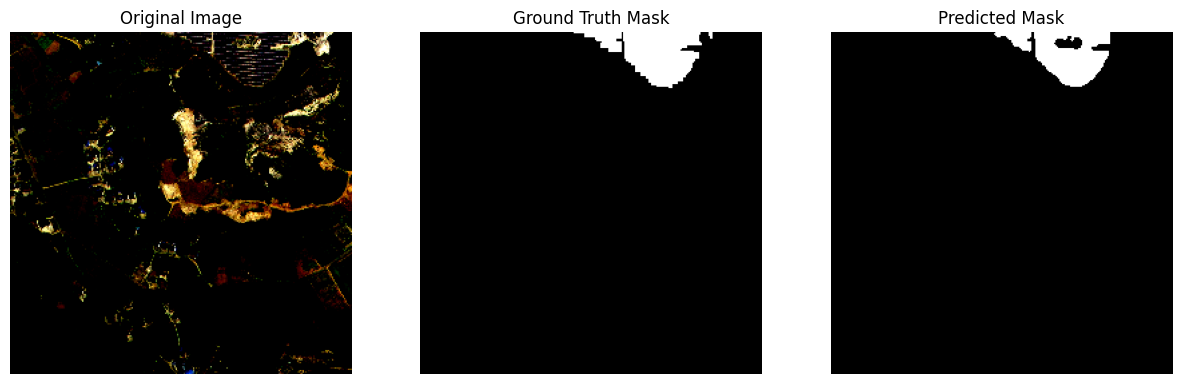

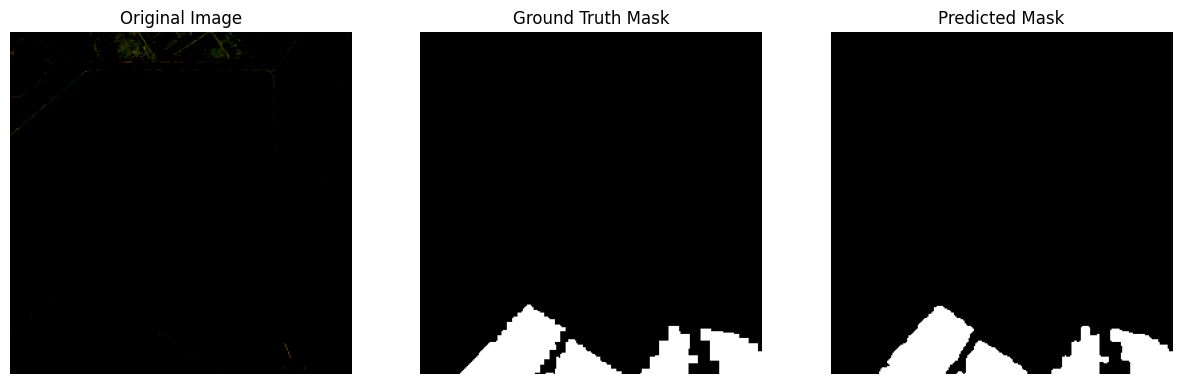

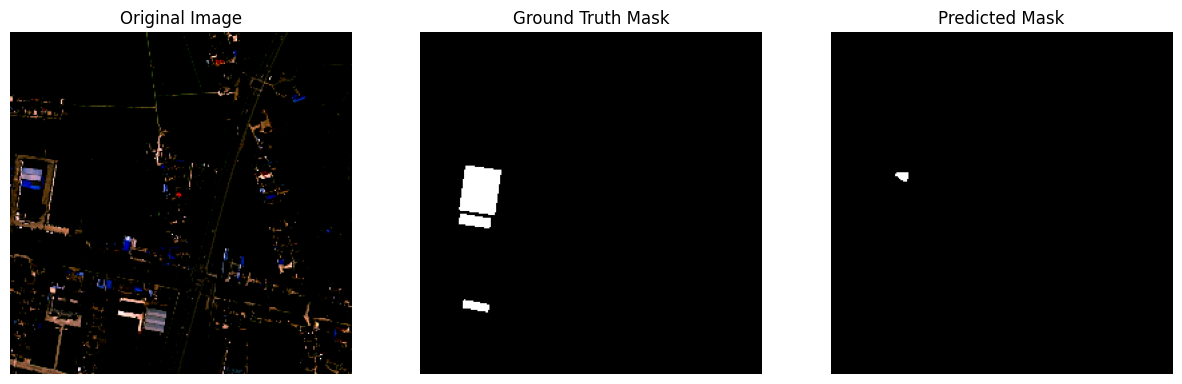

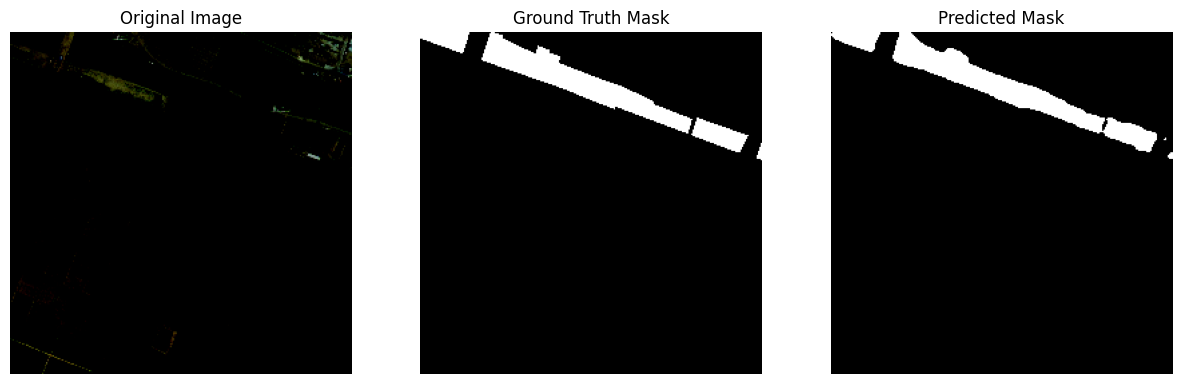

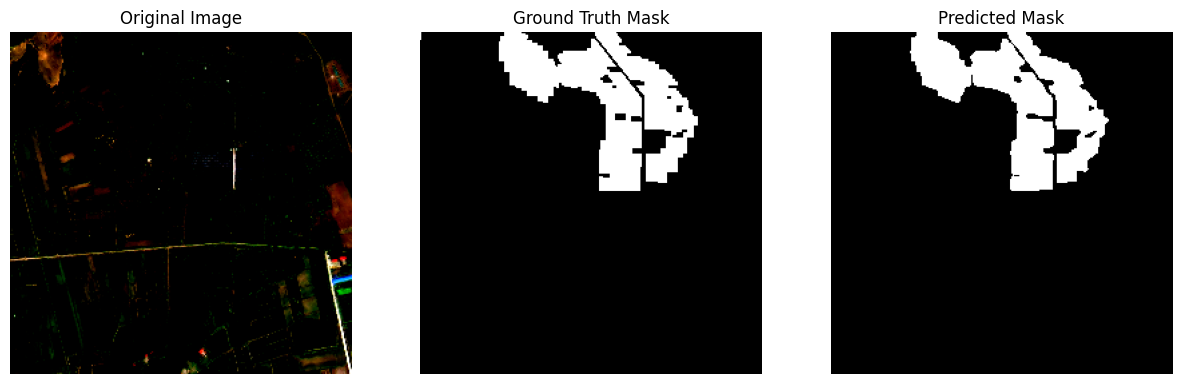

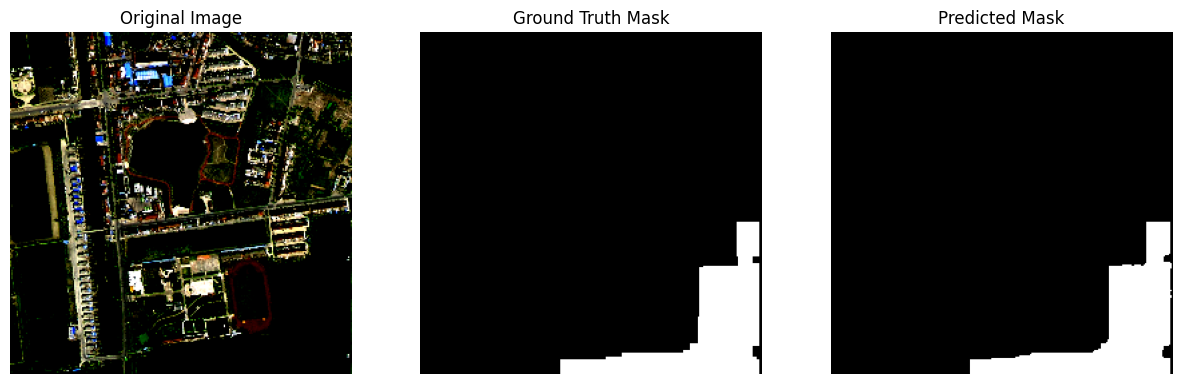

In [ ]:
def visualize_predictions(model, dataloader):
    model.eval()
    c = 0
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)  # Forward pass
            preds = torch.sigmoid(outputs)  # Apply Sigmoid
            preds = (preds > 0.5).float()  # Threshold to binary

            # Convert to NumPy for visualization
            image_np = images[0].cpu().permute(1, 2, 0).numpy()
            mask_np = masks[0].cpu().numpy()
            pred_np = preds[0].cpu().squeeze().numpy()
            pred_np[pred_np<=0] = 0

            # Plot original, ground truth, and prediction
            fig, ax = plt.subplots(1, 3, figsize=(15, 5))
            ax[0].imshow(image_np)
            ax[0].set_title("Original Image")
            ax[0].axis("off")

            ax[1].imshow(mask_np, cmap="gray")
            ax[1].set_title("Ground Truth Mask")
            ax[1].axis("off")

            ax[2].imshow(pred_np, cmap="gray")
            ax[2].set_title("Predicted Mask")
            ax[2].axis("off")

            plt.show()
            if c == 5:
              break  # Show only 1 example
            c+=1

# Visualize predictions
visualize_predictions(model, val_loader)

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    total_dice, total_iou, total_acc = 0.0, 0.0, 0.0
    num_samples = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.cuda(), masks.cuda()
            outputs = model(images)

            total_dice += dice_score(outputs, masks.unsqueeze(1))
            total_iou += iou_score(outputs, masks.unsqueeze(1))
            total_acc += pixel_accuracy(outputs, masks.unsqueeze(1))

            num_samples += 1

    print(f"✅ Average Dice Score: {total_dice / num_samples:.4f}")
    print(f"✅ Average IoU Score: {total_iou / num_samples:.4f}")
    print(f"✅ Average Pixel Accuracy: {total_acc / num_samples:.4f}")

# Run evaluation
evaluate_model(model, val_loader)

✅ Average Dice Score: 0.9256
✅ Average IoU Score: 0.8632
✅ Average Pixel Accuracy: 0.9823


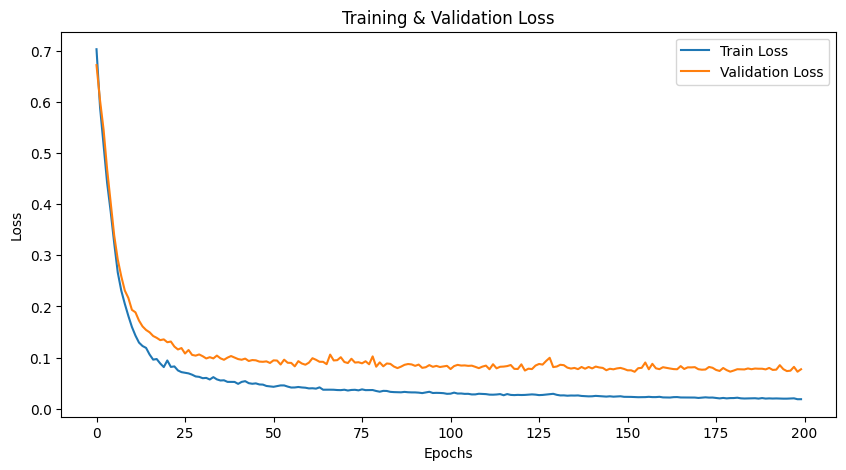

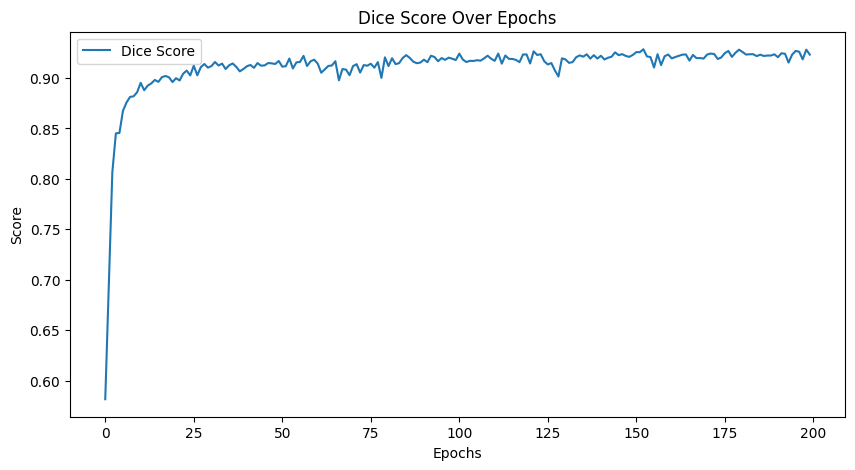

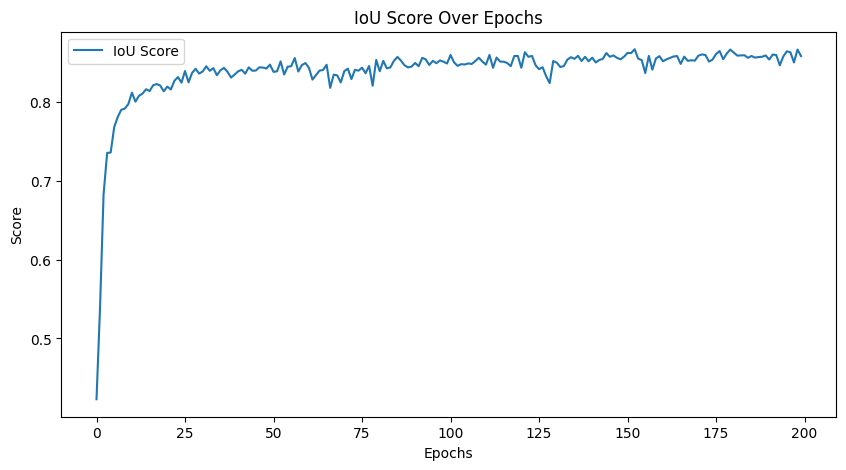

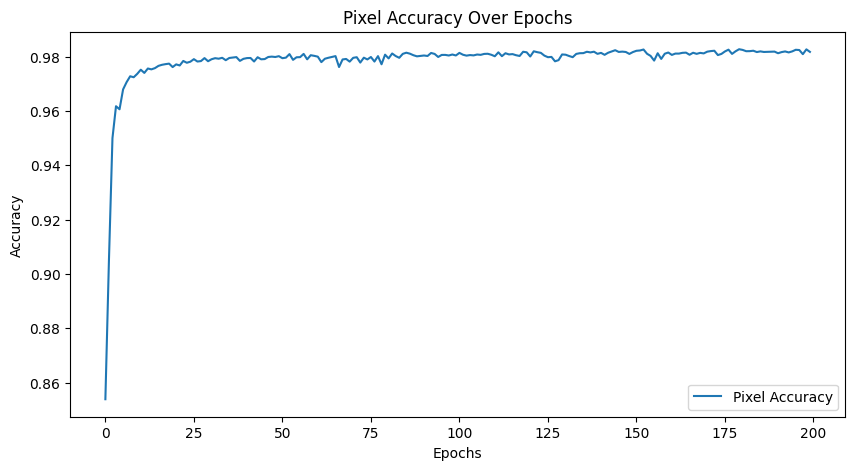

In [ ]:
# Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

# Plot Dice Score
plt.figure(figsize=(10, 5))
plt.plot(dice_scores, label="Dice Score")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("Dice Score Over Epochs")
plt.legend()
plt.show()

# Plot IoU Score
plt.figure(figsize=(10, 5))
plt.plot(iou_scores, label="IoU Score")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("IoU Score Over Epochs")
plt.legend()
plt.show()

# Plot Pixel Accuracy
plt.figure(figsize=(10, 5))
plt.plot(acc_scores, label="Pixel Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Pixel Accuracy Over Epochs")
plt.legend()
plt.show()


In [ ]:
# Save the trained model (recommended: save only state_dict)
torch.save(model.state_dict(), "unet_efficientdet-b7_imagenet.pth")

print("✅ Model saved successfully!")

✅ Model saved successfully!


# Modified Models

## Small Transformer

In [ ]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define Transformations
transform = A.Compose([
    A.Resize(512, 512),  # Resize to SegFormer input size
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Custom Dataset Class
class SolarPanelDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace(".bmp", "_label.bmp"))

        # Load Image & Mask
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype("uint8")  # Convert to binary mask

        # Apply Transformations
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        return image, mask.unsqueeze(0)  # Add channel dimension

# Load Dataset
train_dataset = SolarPanelDataset("/content/dataset/train/images", "/content/dataset/train/labels", transform=transform)
val_dataset = SolarPanelDataset("/content/dataset/val/images", "/content/dataset/val/labels", transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

print(f"✅ Dataset Loaded: {len(train_dataset)} train, {len(val_dataset)} val samples")

✅ Dataset Loaded: 693 train, 276 val samples


###model

In [ ]:
from transformers import SegformerForSemanticSegmentation

# Load SegFormer MiT-B0 (smallest variant)
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=1,  # Binary segmentation (solar panels)
    ignore_mismatched_sizes=True
).cuda()

print("✅ SegFormer (MiT-B0) Loaded Successfully!")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/6.88k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([1]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([1, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ SegFormer (MiT-B0) Loaded Successfully!


In [ ]:
import torch.nn.functional as F
import torch.optim as optim

# Dice Loss
def dice_loss(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return 1 - dice

# Combined Loss
def loss_fn(pred, target):
    bce = F.binary_cross_entropy_with_logits(pred, target)
    return bce + dice_loss(pred, target)

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

In [ ]:
from tqdm import tqdm

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
scaler = torch.cuda.amp.GradScaler()  # Enable Mixed Precision
def train_model(model, train_loader, val_loader, optimizer, num_epochs=10, device="cuda"):
    model.to(device)

    # Lists to store metrics
    train_losses, val_losses = [], []
    dice_scores, iou_scores, acc_scores = [], [], []

    scaler = torch.cuda.amp.GradScaler()  # Enable Mixed Precision (AMP)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # Training Progress Bar
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

        for images, masks in train_loader_tqdm:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()

            # ✅ Enable AMP during forward pass
            with torch.cuda.amp.autocast():
                outputs = model(images).logits  # Extract logits
                outputs = F.interpolate(outputs, size=masks.shape[-2:], mode="bilinear", align_corners=False)  # Resize output
                loss = loss_fn(outputs.float(), masks.float())  # Compute loss

            # ✅ Scale gradients for stable AMP training
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

        # Compute Training Loss
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Compute Validation Metrics
        model.eval()
        total_loss, total_dice, total_iou, total_acc = 0.0, 0.0, 0.0, 0.0
        num_samples = 0

        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)

                with torch.cuda.amp.autocast():  # Use AMP for validation too
                    outputs = model(images).logits
                    outputs = F.interpolate(outputs, size=masks.shape[-2:], mode="bilinear", align_corners=False)

                loss = loss_fn(outputs.float(), masks.float())
                total_loss += loss.item()

                # Compute Validation Metrics
                total_dice += dice_score(outputs, masks)
                total_iou += iou_score(outputs, masks)
                total_acc += pixel_accuracy(outputs, masks)

                num_samples += 1

        avg_val_loss = total_loss / num_samples
        avg_dice = total_dice / num_samples
        avg_iou = total_iou / num_samples
        avg_acc = total_acc / num_samples

        # Store validation metrics
        val_losses.append(avg_val_loss)
        dice_scores.append(avg_dice)
        iou_scores.append(avg_iou)
        acc_scores.append(avg_acc)

        print(f"✅ Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Dice: {avg_dice:.4f} | IoU: {avg_iou:.4f} | Acc: {avg_acc:.4f}")

    print("🎯 Training Complete!")

    # Return stored metrics
    return train_losses, val_losses, dice_scores, iou_scores, acc_scores

# Train Model
train_losses, val_losses, dice_scores, iou_scores, acc_scores = train_model(
    model, train_loader, val_loader, optimizer, num_epochs=50, device="cuda"
)

<ipython-input-57-5b5e7af3926d>:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Enable Mixed Precision
<ipython-input-57-5b5e7af3926d>:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Enable Mixed Precision (AMP)
Epoch 1/50:   0%|          | 0/96 [00:00<?, ?it/s]<ipython-input-57-5b5e7af3926d>:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-57-5b5e7af3926d>:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Use AMP for validation too


✅ Epoch [1/50] | Train Loss: 0.0493 | Val Loss: 0.0499 | Dice: 0.9726 | IoU: 0.9470 | Acc: 0.9937


✅ Epoch [2/50] | Train Loss: 0.0489 | Val Loss: 0.0493 | Dice: 0.9729 | IoU: 0.9476 | Acc: 0.9938


✅ Epoch [3/50] | Train Loss: 0.0514 | Val Loss: 0.0500 | Dice: 0.9723 | IoU: 0.9465 | Acc: 0.9937


✅ Epoch [4/50] | Train Loss: 0.0487 | Val Loss: 0.0489 | Dice: 0.9731 | IoU: 0.9479 | Acc: 0.9938


✅ Epoch [5/50] | Train Loss: 0.0484 | Val Loss: 0.0483 | Dice: 0.9734 | IoU: 0.9484 | Acc: 0.9939


✅ Epoch [6/50] | Train Loss: 0.0484 | Val Loss: 0.0483 | Dice: 0.9735 | IoU: 0.9486 | Acc: 0.9939


✅ Epoch [7/50] | Train Loss: 0.0473 | Val Loss: 0.0498 | Dice: 0.9726 | IoU: 0.9470 | Acc: 0.9938


✅ Epoch [8/50] | Train Loss: 0.0464 | Val Loss: 0.0479 | Dice: 0.9737 | IoU: 0.9490 | Acc: 0.9940


✅ Epoch [9/50] | Train Loss: 0.0487 | Val Loss: 0.0482 | Dice: 0.9734 | IoU: 0.9486 | Acc: 0.9939


✅ Epoch [10/50] | Train Loss: 0.0470 | Val Loss: 0.0475 | Dice: 0.9738 | IoU: 0.9492 | Acc: 0.9940


✅ Epoch [11/50] | Train Loss: 0.0490 | Val Loss: 0.0484 | Dice: 0.9733 | IoU: 0.9482 | Acc: 0.9939


✅ Epoch [12/50] | Train Loss: 0.0500 | Val Loss: 0.0525 | Dice: 0.9709 | IoU: 0.9445 | Acc: 0.9936


✅ Epoch [13/50] | Train Loss: 0.0542 | Val Loss: 0.0638 | Dice: 0.9651 | IoU: 0.9337 | Acc: 0.9923


✅ Epoch [14/50] | Train Loss: 0.0573 | Val Loss: 0.0610 | Dice: 0.9660 | IoU: 0.9375 | Acc: 0.9932


✅ Epoch [15/50] | Train Loss: 0.0493 | Val Loss: 0.0488 | Dice: 0.9731 | IoU: 0.9480 | Acc: 0.9939


✅ Epoch [16/50] | Train Loss: 0.0475 | Val Loss: 0.0484 | Dice: 0.9732 | IoU: 0.9482 | Acc: 0.9939


✅ Epoch [17/50] | Train Loss: 0.0479 | Val Loss: 0.0483 | Dice: 0.9733 | IoU: 0.9484 | Acc: 0.9940


✅ Epoch [18/50] | Train Loss: 0.0466 | Val Loss: 0.0476 | Dice: 0.9738 | IoU: 0.9492 | Acc: 0.9940


✅ Epoch [19/50] | Train Loss: 0.0470 | Val Loss: 0.0480 | Dice: 0.9735 | IoU: 0.9487 | Acc: 0.9940


✅ Epoch [20/50] | Train Loss: 0.0498 | Val Loss: 0.0479 | Dice: 0.9736 | IoU: 0.9488 | Acc: 0.9940


✅ Epoch [21/50] | Train Loss: 0.0549 | Val Loss: 0.0600 | Dice: 0.9670 | IoU: 0.9394 | Acc: 0.9933


✅ Epoch [22/50] | Train Loss: 0.0473 | Val Loss: 0.0484 | Dice: 0.9735 | IoU: 0.9487 | Acc: 0.9939


✅ Epoch [23/50] | Train Loss: 0.0678 | Val Loss: 0.0568 | Dice: 0.9698 | IoU: 0.9416 | Acc: 0.9930


✅ Epoch [24/50] | Train Loss: 0.0534 | Val Loss: 0.0488 | Dice: 0.9731 | IoU: 0.9480 | Acc: 0.9939


✅ Epoch [25/50] | Train Loss: 0.0522 | Val Loss: 0.0520 | Dice: 0.9715 | IoU: 0.9450 | Acc: 0.9935


✅ Epoch [26/50] | Train Loss: 0.0517 | Val Loss: 0.0504 | Dice: 0.9723 | IoU: 0.9465 | Acc: 0.9937


✅ Epoch [27/50] | Train Loss: 0.0534 | Val Loss: 0.0538 | Dice: 0.9709 | IoU: 0.9440 | Acc: 0.9933


✅ Epoch [28/50] | Train Loss: 0.0506 | Val Loss: 0.0497 | Dice: 0.9725 | IoU: 0.9468 | Acc: 0.9938


✅ Epoch [29/50] | Train Loss: 0.0482 | Val Loss: 0.0486 | Dice: 0.9733 | IoU: 0.9484 | Acc: 0.9939


✅ Epoch [30/50] | Train Loss: 0.0469 | Val Loss: 0.0484 | Dice: 0.9732 | IoU: 0.9481 | Acc: 0.9939


✅ Epoch [31/50] | Train Loss: 0.0475 | Val Loss: 0.0489 | Dice: 0.9732 | IoU: 0.9482 | Acc: 0.9939


✅ Epoch [32/50] | Train Loss: 0.0454 | Val Loss: 0.0478 | Dice: 0.9738 | IoU: 0.9492 | Acc: 0.9940


✅ Epoch [33/50] | Train Loss: 0.0520 | Val Loss: 0.0516 | Dice: 0.9715 | IoU: 0.9452 | Acc: 0.9935


✅ Epoch [34/50] | Train Loss: 0.0541 | Val Loss: 0.0515 | Dice: 0.9720 | IoU: 0.9460 | Acc: 0.9937


✅ Epoch [35/50] | Train Loss: 0.0489 | Val Loss: 0.0510 | Dice: 0.9723 | IoU: 0.9464 | Acc: 0.9935


✅ Epoch [36/50] | Train Loss: 0.0541 | Val Loss: 0.0511 | Dice: 0.9723 | IoU: 0.9465 | Acc: 0.9936


✅ Epoch [37/50] | Train Loss: 0.0483 | Val Loss: 0.0493 | Dice: 0.9729 | IoU: 0.9477 | Acc: 0.9938


✅ Epoch [38/50] | Train Loss: 0.0466 | Val Loss: 0.0525 | Dice: 0.9720 | IoU: 0.9461 | Acc: 0.9936


✅ Epoch [39/50] | Train Loss: 0.0527 | Val Loss: 0.0514 | Dice: 0.9714 | IoU: 0.9448 | Acc: 0.9936


✅ Epoch [40/50] | Train Loss: 0.0488 | Val Loss: 0.0471 | Dice: 0.9740 | IoU: 0.9496 | Acc: 0.9941


✅ Epoch [41/50] | Train Loss: 0.0464 | Val Loss: 0.0467 | Dice: 0.9742 | IoU: 0.9500 | Acc: 0.9941


✅ Epoch [42/50] | Train Loss: 0.0449 | Val Loss: 0.0458 | Dice: 0.9748 | IoU: 0.9511 | Acc: 0.9942


✅ Epoch [43/50] | Train Loss: 0.0455 | Val Loss: 0.0460 | Dice: 0.9746 | IoU: 0.9507 | Acc: 0.9942


✅ Epoch [44/50] | Train Loss: 0.0496 | Val Loss: 0.0510 | Dice: 0.9720 | IoU: 0.9461 | Acc: 0.9937


✅ Epoch [45/50] | Train Loss: 0.0535 | Val Loss: 0.0588 | Dice: 0.9677 | IoU: 0.9381 | Acc: 0.9927


✅ Epoch [46/50] | Train Loss: 0.0568 | Val Loss: 0.0515 | Dice: 0.9717 | IoU: 0.9455 | Acc: 0.9935


✅ Epoch [47/50] | Train Loss: 0.0483 | Val Loss: 0.0514 | Dice: 0.9717 | IoU: 0.9454 | Acc: 0.9936


✅ Epoch [48/50] | Train Loss: 0.0513 | Val Loss: 0.0510 | Dice: 0.9720 | IoU: 0.9461 | Acc: 0.9936


✅ Epoch [49/50] | Train Loss: 0.0482 | Val Loss: 0.0543 | Dice: 0.9694 | IoU: 0.9422 | Acc: 0.9934


✅ Epoch [50/50] | Train Loss: 0.0453 | Val Loss: 0.0488 | Dice: 0.9734 | IoU: 0.9486 | Acc: 0.9939
🎯 Training Complete!


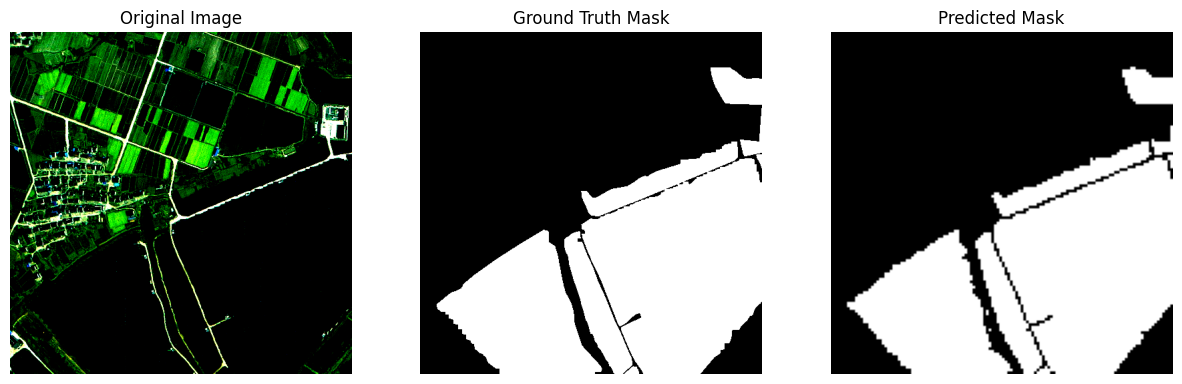

In [ ]:
# Define transformation (same as training)
val_transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

def visualize_sample(val_dataset, model, idx=0):
    model.eval()

    # Load image and mask from validation set
    image, mask = val_dataset[idx]
    orig_image = np.moveaxis(image.numpy(), 0, -1)  # Convert from (C, H, W) to (H, W, C)

    # Move image to GPU
    image = image.unsqueeze(0).cuda()

    with torch.no_grad():
        output = model(image).logits  # Get raw logits
        pred_mask = torch.sigmoid(output).squeeze().cpu().numpy()  # Convert logits to probabilities
        pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Convert to binary mask

    # Resize ground truth mask for plotting
    mask = mask.squeeze().numpy()

    # Plot the results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(orig_image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()

# Run visualization for a random validation sample
visualize_sample(val_dataset, model, idx=10)

In [ ]:
# Save the trained model (recommended: save only state_dict)
torch.save(model.state_dict(), "segformer-b0-finetuned-ade-512-512_v2.pth")

print("✅ Model saved successfully!")

✅ Model saved successfully!


In [ ]:
from tqdm import tqdm
import torch.nn.functional as F

def evaluate_model(model, dataloader, device="cuda"):
    model.eval()
    total_dice, total_iou, total_acc = 0.0, 0.0, 0.0
    num_samples = 0

    # Validation Progress Bar
    dataloader_tqdm = tqdm(dataloader, desc="🔍 Evaluating", leave=False)

    with torch.no_grad():
        for images, masks in dataloader_tqdm:
            images, masks = images.to(device), masks.to(device)

            with torch.cuda.amp.autocast():  # ✅ Enable AMP for efficient inference
                outputs = model(images).logits  # Extract logits
                outputs = F.interpolate(outputs, size=masks.shape[-2:], mode="bilinear", align_corners=False)

            # Compute Metrics
            total_dice += dice_score(outputs, masks)
            total_iou += iou_score(outputs, masks)
            total_acc += pixel_accuracy(outputs, masks)
            num_samples += 1

    # Compute Averages
    avg_dice = total_dice / num_samples
    avg_iou = total_iou / num_samples
    avg_acc = total_acc / num_samples

    # Print Final Evaluation Metrics
    print(f"✅ Average Dice Score: {avg_dice:.4f}")
    print(f"✅ Average IoU Score: {avg_iou:.4f}")
    print(f"✅ Average Pixel Accuracy: {avg_acc:.4f}")

# Run Evaluation
evaluate_model(model, val_loader, device="cuda")


🔍 Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]<ipython-input-59-d6eabb6e4721>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # ✅ Enable AMP for efficient inference
                                                              

✅ Average Dice Score: 0.9734
✅ Average IoU Score: 0.9486
✅ Average Pixel Accuracy: 0.9939


### Acc Curve

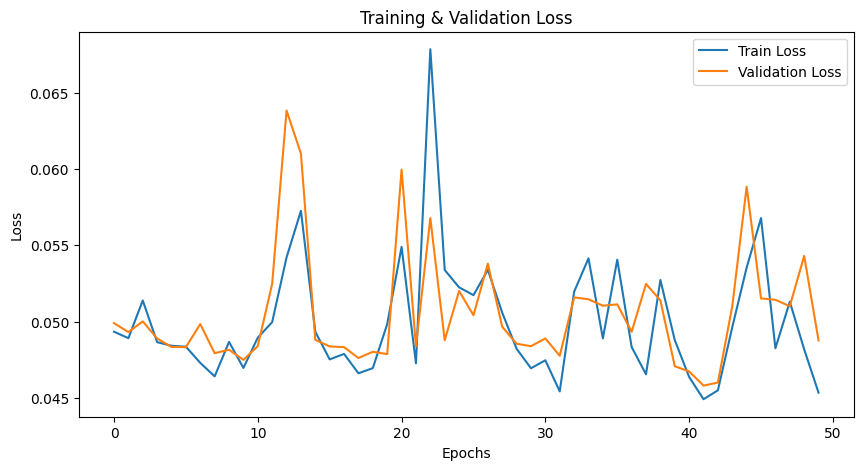

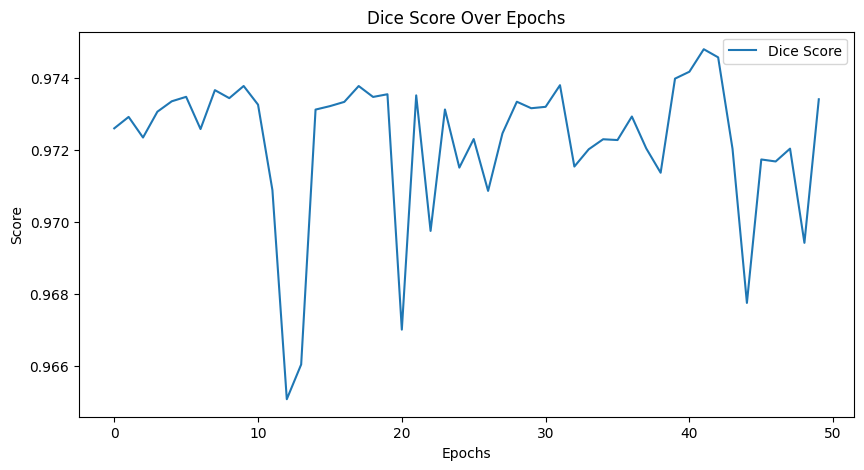

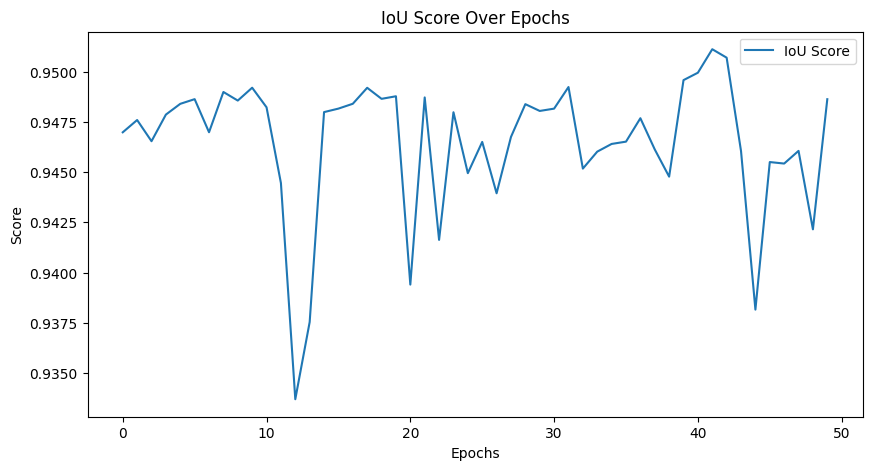

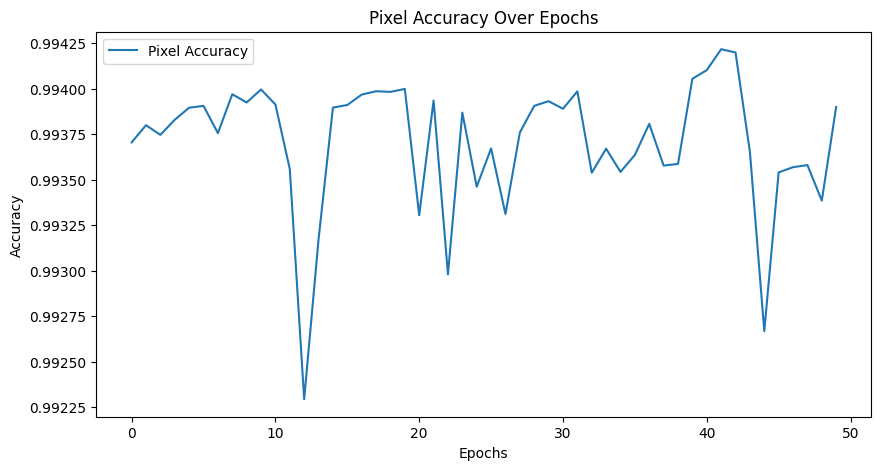

In [ ]:
# Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

# Plot Dice Score
plt.figure(figsize=(10, 5))
plt.plot(dice_scores, label="Dice Score")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("Dice Score Over Epochs")
plt.legend()
plt.show()

# Plot IoU Score
plt.figure(figsize=(10, 5))
plt.plot(iou_scores, label="IoU Score")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("IoU Score Over Epochs")
plt.legend()
plt.show()

# Plot Pixel Accuracy
plt.figure(figsize=(10, 5))
plt.plot(acc_scores, label="Pixel Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Pixel Accuracy Over Epochs")
plt.legend()
plt.show()


## Attention UNET



In [ ]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define Transformations
transform = A.Compose([
    A.Resize(256, 256),  # Resize to SegFormer input size
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=[0.5], std=[0.5]),
    ToTensorV2()
])

# Custom Dataset Class
class SolarPanelDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace(".bmp", "_label.bmp"))

        # Load Image & Mask
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype("uint8")  # Convert to binary mask
        # Apply Transformations
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        return image, mask.unsqueeze(0)  # Add channel dimension

# Load Dataset
train_dataset = SolarPanelDataset("/content/dataset/train/images", "/content/dataset/train/labels", transform=transform)
val_dataset = SolarPanelDataset("/content/dataset/val/images", "/content/dataset/val/labels", transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

print(f"✅ Dataset Loaded: {len(train_dataset)} train, {len(val_dataset)} val samples")

✅ Dataset Loaded: 693 train, 276 val samples


In [ ]:
for images, masks in train_loader:
  print(images.shape)
  print(masks.shape)
  break

torch.Size([8, 3, 256, 256])
torch.Size([8, 1, 256, 256])


In [ ]:
import torch.nn.functional as F
import torch.optim as optim

# Dice Loss
def dice_loss(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return 1 - dice

# Combined Loss
def loss_fn(pred, target):
    bce = F.binary_cross_entropy_with_logits(pred, target)
    return bce + dice_loss(pred, target)

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

In [ ]:
class AttentionBlock(nn.Module):
    """ Attention mechanism to focus on relevant features. """
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = F.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class DoubleConv(nn.Module):
    """ Double Convolution block in U-Net """
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class Encoder(nn.Module):
    """ Encoder with Downsampling """
    def __init__(self, in_channels):
        super(Encoder, self).__init__()
        self.conv1 = DoubleConv(in_channels, 64)
        self.conv2 = DoubleConv(64, 128)
        self.conv3 = DoubleConv(128, 256)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(self.pool(x1))
        x3 = self.conv3(self.pool(x2))
        return x1, x2, x3

class Decoder(nn.Module):
    """ Decoder with Upsampling """
    def __init__(self, out_channels):
        super(Decoder, self).__init__()
        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(256, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(128, 64)
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x3, x2, x1):
        x = self.up1(x3)
        x = torch.cat([x, x2], dim=1)
        x = self.conv1(x)
        x = self.up2(x)
        x = torch.cat([x, x1], dim=1)
        x = self.conv2(x)
        return self.final_conv(x)

class AttentionUNet(nn.Module):
    """ Full Attention U-Net Model """
    def __init__(self, in_channels=3, out_channels=1):
        super(AttentionUNet, self).__init__()
        self.encoder = Encoder(in_channels)
        self.attn = AttentionBlock(256, 256, 128)
        self.decoder = Decoder(out_channels)

    def forward(self, x):
        original_input = x  # Retain input
        x1, x2, x3 = self.encoder(x)
        attn_x3 = self.attn(x3, x3)
        output = self.decoder(attn_x3, x2, x1)
        return output


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, Loss, Optimizer
model = AttentionUNet(in_channels=3, out_channels=1).to(device)
sample_input = torch.randn(1, 3, 256, 256)
sample_input = sample_input.to(device)

In [ ]:
# Forward pass through the model
output = model(sample_input)
print("Model Output Shape:", output.shape)

Model Output Shape: torch.Size([1, 1, 256, 256])


In [ ]:
# Loss Function: BCE + Dice Loss
class DiceBCELoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceBCELoss, self).__init__()
        self.smooth = smooth
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, preds, targets):
        bce_loss = self.bce(preds, targets)

        preds = torch.sigmoid(preds)
        intersection = (preds * targets).sum(dim=(2, 3))
        dice_loss = 1 - ((2. * intersection + self.smooth) / (preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3)) + self.smooth)).mean()

        return 0.5 * bce_loss + 0.5 * dice_loss

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super(FocalLoss, self).__init__()
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
        pt = torch.exp(-BCE)
        F_loss = (1 - pt) ** self.gamma * BCE
        return F_loss.mean()

In [ ]:
import torch

def dice_score(preds, targets, smooth=1e-5):
    preds = torch.sigmoid(preds)  # Ensure sigmoid activation for binary segmentation
    preds = (preds > 0.5).float()  # Convert to binary mask

    intersection = (preds * targets).sum(dim=(2, 3))  # Sum over spatial dimensions
    union = preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))

    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean().item()  # Return as a scalar
def iou_score(preds, targets, smooth=1e-5):
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()

    intersection = (preds * targets).sum(dim=(2, 3))
    union = preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3)) - intersection

    iou = (intersection + smooth) / (union + smooth)
    return iou.mean().item()
def pixel_accuracy(preds, targets):
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()

    correct = (preds == targets).float().sum()
    total = targets.numel()  # Total number of pixels

    return (correct / total).item()

In [ ]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AttentionUNet().to(device)
scaler = GradScaler()  # Enable Mixed Precision

def train_model(model, train_loader, val_loader, optimizer, num_epochs=10, device="cuda"):
    model.to(device)

    # Lists to store metrics
    train_losses, val_losses = [], []
    dice_scores, iou_scores, acc_scores = [], [], []

    scaler = GradScaler()  # Enable Mixed Precision (AMP)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # Training Progress Bar
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

        for images, masks in train_loader_tqdm:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()

            # ✅ Enable AMP during forward pass
            with autocast():
                outputs = model(images)
                loss = FocalLoss()(outputs.float(), masks.float())  # Compute loss

            # ✅ Scale gradients for stable AMP training
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

        # Compute Training Loss
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Compute Validation Metrics
        model.eval()
        total_loss, total_dice, total_iou, total_acc = 0.0, 0.0, 0.0, 0.0
        num_samples = 0

        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)

                with autocast():  # Use AMP for validation too
                    outputs = model(images)
                    outputs = F.interpolate(outputs, size=masks.shape[-2:], mode="bilinear", align_corners=False)
                loss = DiceBCELoss()(outputs.float(), masks.float())
                total_loss += loss.item()

                # Compute Validation Metrics
                total_dice += dice_score(outputs, masks)
                total_iou += iou_score(outputs, masks)
                total_acc += pixel_accuracy(outputs, masks)

                num_samples += 1

        avg_val_loss = total_loss / num_samples
        avg_dice = total_dice / num_samples
        avg_iou = total_iou / num_samples
        avg_acc = total_acc / num_samples

        # Store validation metrics
        val_losses.append(avg_val_loss)
        dice_scores.append(avg_dice)
        iou_scores.append(avg_iou)
        acc_scores.append(avg_acc)

        print(f"✅ Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Dice: {avg_dice:.4f} | IoU: {avg_iou:.4f} | Acc: {avg_acc:.4f}")

    print("🎯 Training Complete!")

    # Return stored metrics
    return train_losses, val_losses, dice_scores, iou_scores, acc_scores

# Optimizer & Training
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
train_losses, val_losses, dice_scores, iou_scores, acc_scores = train_model(
    model, train_loader, val_loader, optimizer, num_epochs=200, device="cuda"
)


<ipython-input-120-8ef9f6fbe3c0>:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Enable Mixed Precision
<ipython-input-120-8ef9f6fbe3c0>:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Enable Mixed Precision (AMP)
Epoch 1/200:   0%|          | 0/87 [00:00<?, ?it/s]<ipython-input-120-8ef9f6fbe3c0>:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-120-8ef9f6fbe3c0>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Use AMP for validation too


✅ Epoch [1/200] | Train Loss: 0.1090 | Val Loss: 0.5548 | Dice: 0.0000 | IoU: 0.0000 | Acc: 0.8666


✅ Epoch [2/200] | Train Loss: 0.0596 | Val Loss: 0.5140 | Dice: 0.4200 | IoU: 0.3428 | Acc: 0.9229


✅ Epoch [3/200] | Train Loss: 0.0471 | Val Loss: 0.4443 | Dice: 0.6778 | IoU: 0.5899 | Acc: 0.9497


✅ Epoch [4/200] | Train Loss: 0.0376 | Val Loss: 0.3671 | Dice: 0.5974 | IoU: 0.5186 | Acc: 0.9483


✅ Epoch [5/200] | Train Loss: 0.0342 | Val Loss: 0.5201 | Dice: 0.7149 | IoU: 0.6194 | Acc: 0.9525


✅ Epoch [6/200] | Train Loss: 0.0350 | Val Loss: 0.4910 | Dice: 0.7211 | IoU: 0.6349 | Acc: 0.9586


✅ Epoch [7/200] | Train Loss: 0.0317 | Val Loss: 0.4115 | Dice: 0.7266 | IoU: 0.6419 | Acc: 0.9607


✅ Epoch [8/200] | Train Loss: 0.0320 | Val Loss: 0.4041 | Dice: 0.7240 | IoU: 0.6356 | Acc: 0.9531


✅ Epoch [9/200] | Train Loss: 0.0303 | Val Loss: 0.4563 | Dice: 0.7320 | IoU: 0.6446 | Acc: 0.9577


✅ Epoch [10/200] | Train Loss: 0.0297 | Val Loss: 0.3422 | Dice: 0.6769 | IoU: 0.5999 | Acc: 0.9564


✅ Epoch [11/200] | Train Loss: 0.0280 | Val Loss: 0.4515 | Dice: 0.7517 | IoU: 0.6558 | Acc: 0.9535


✅ Epoch [12/200] | Train Loss: 0.0312 | Val Loss: 0.3807 | Dice: 0.7384 | IoU: 0.6621 | Acc: 0.9632


✅ Epoch [13/200] | Train Loss: 0.0255 | Val Loss: 0.3931 | Dice: 0.7632 | IoU: 0.6861 | Acc: 0.9679


✅ Epoch [14/200] | Train Loss: 0.0244 | Val Loss: 0.3897 | Dice: 0.7669 | IoU: 0.6888 | Acc: 0.9676


✅ Epoch [15/200] | Train Loss: 0.0256 | Val Loss: 0.4916 | Dice: 0.7618 | IoU: 0.6682 | Acc: 0.9552


✅ Epoch [16/200] | Train Loss: 0.0233 | Val Loss: 0.3729 | Dice: 0.7825 | IoU: 0.7069 | Acc: 0.9695


✅ Epoch [17/200] | Train Loss: 0.0243 | Val Loss: 0.3725 | Dice: 0.7801 | IoU: 0.7021 | Acc: 0.9677


✅ Epoch [18/200] | Train Loss: 0.0235 | Val Loss: 0.3757 | Dice: 0.7845 | IoU: 0.7099 | Acc: 0.9698


✅ Epoch [19/200] | Train Loss: 0.0247 | Val Loss: 0.3153 | Dice: 0.7625 | IoU: 0.6875 | Acc: 0.9664


✅ Epoch [20/200] | Train Loss: 0.0242 | Val Loss: 0.4463 | Dice: 0.7908 | IoU: 0.7055 | Acc: 0.9687


✅ Epoch [21/200] | Train Loss: 0.0223 | Val Loss: 0.3276 | Dice: 0.7830 | IoU: 0.7051 | Acc: 0.9699


✅ Epoch [22/200] | Train Loss: 0.0207 | Val Loss: 0.3981 | Dice: 0.7750 | IoU: 0.6866 | Acc: 0.9625


✅ Epoch [23/200] | Train Loss: 0.0225 | Val Loss: 0.2829 | Dice: 0.7578 | IoU: 0.6834 | Acc: 0.9664


✅ Epoch [24/200] | Train Loss: 0.0210 | Val Loss: 0.3523 | Dice: 0.7921 | IoU: 0.7133 | Acc: 0.9666


✅ Epoch [25/200] | Train Loss: 0.0228 | Val Loss: 0.3589 | Dice: 0.7861 | IoU: 0.7107 | Acc: 0.9701


✅ Epoch [26/200] | Train Loss: 0.0212 | Val Loss: 0.4555 | Dice: 0.7124 | IoU: 0.6114 | Acc: 0.9388


✅ Epoch [27/200] | Train Loss: 0.0198 | Val Loss: 0.3487 | Dice: 0.8111 | IoU: 0.7370 | Acc: 0.9737


✅ Epoch [28/200] | Train Loss: 0.0197 | Val Loss: 0.4490 | Dice: 0.7647 | IoU: 0.6697 | Acc: 0.9569


✅ Epoch [29/200] | Train Loss: 0.0194 | Val Loss: 0.3263 | Dice: 0.8214 | IoU: 0.7461 | Acc: 0.9742


✅ Epoch [30/200] | Train Loss: 0.0192 | Val Loss: 0.2809 | Dice: 0.7068 | IoU: 0.6325 | Acc: 0.9607


✅ Epoch [31/200] | Train Loss: 0.0202 | Val Loss: 0.3289 | Dice: 0.8093 | IoU: 0.7323 | Acc: 0.9728


✅ Epoch [32/200] | Train Loss: 0.0194 | Val Loss: 0.3173 | Dice: 0.7935 | IoU: 0.7233 | Acc: 0.9703


✅ Epoch [33/200] | Train Loss: 0.0201 | Val Loss: 0.3780 | Dice: 0.8082 | IoU: 0.7338 | Acc: 0.9725


✅ Epoch [34/200] | Train Loss: 0.0192 | Val Loss: 0.3034 | Dice: 0.8227 | IoU: 0.7484 | Acc: 0.9743


✅ Epoch [35/200] | Train Loss: 0.0179 | Val Loss: 0.2810 | Dice: 0.8200 | IoU: 0.7502 | Acc: 0.9750


✅ Epoch [36/200] | Train Loss: 0.0180 | Val Loss: 0.2813 | Dice: 0.7973 | IoU: 0.7271 | Acc: 0.9731


✅ Epoch [37/200] | Train Loss: 0.0174 | Val Loss: 0.2922 | Dice: 0.7776 | IoU: 0.7063 | Acc: 0.9695


✅ Epoch [38/200] | Train Loss: 0.0170 | Val Loss: 0.3535 | Dice: 0.8394 | IoU: 0.7663 | Acc: 0.9759


✅ Epoch [39/200] | Train Loss: 0.0172 | Val Loss: 0.3012 | Dice: 0.8320 | IoU: 0.7620 | Acc: 0.9756


✅ Epoch [40/200] | Train Loss: 0.0167 | Val Loss: 0.3651 | Dice: 0.8280 | IoU: 0.7478 | Acc: 0.9714


✅ Epoch [41/200] | Train Loss: 0.0176 | Val Loss: 0.3393 | Dice: 0.8421 | IoU: 0.7695 | Acc: 0.9762


✅ Epoch [42/200] | Train Loss: 0.0181 | Val Loss: 0.3077 | Dice: 0.7277 | IoU: 0.6470 | Acc: 0.9664


✅ Epoch [43/200] | Train Loss: 0.0173 | Val Loss: 0.3095 | Dice: 0.8433 | IoU: 0.7736 | Acc: 0.9766


✅ Epoch [44/200] | Train Loss: 0.0149 | Val Loss: 0.2968 | Dice: 0.8285 | IoU: 0.7528 | Acc: 0.9710


✅ Epoch [45/200] | Train Loss: 0.0165 | Val Loss: 0.2576 | Dice: 0.8349 | IoU: 0.7669 | Acc: 0.9786


✅ Epoch [46/200] | Train Loss: 0.0153 | Val Loss: 0.3425 | Dice: 0.8457 | IoU: 0.7737 | Acc: 0.9759


✅ Epoch [47/200] | Train Loss: 0.0176 | Val Loss: 0.2883 | Dice: 0.8076 | IoU: 0.7402 | Acc: 0.9753


✅ Epoch [48/200] | Train Loss: 0.0162 | Val Loss: 0.3051 | Dice: 0.8072 | IoU: 0.7365 | Acc: 0.9757


✅ Epoch [49/200] | Train Loss: 0.0150 | Val Loss: 0.2744 | Dice: 0.8477 | IoU: 0.7781 | Acc: 0.9790


✅ Epoch [50/200] | Train Loss: 0.0156 | Val Loss: 0.2981 | Dice: 0.8428 | IoU: 0.7732 | Acc: 0.9787


✅ Epoch [51/200] | Train Loss: 0.0148 | Val Loss: 0.3116 | Dice: 0.8283 | IoU: 0.7588 | Acc: 0.9781


✅ Epoch [52/200] | Train Loss: 0.0155 | Val Loss: 0.2544 | Dice: 0.8075 | IoU: 0.7395 | Acc: 0.9755


✅ Epoch [53/200] | Train Loss: 0.0149 | Val Loss: 0.3297 | Dice: 0.8472 | IoU: 0.7764 | Acc: 0.9798


✅ Epoch [54/200] | Train Loss: 0.0159 | Val Loss: 0.2788 | Dice: 0.8544 | IoU: 0.7862 | Acc: 0.9789


✅ Epoch [55/200] | Train Loss: 0.0173 | Val Loss: 0.2602 | Dice: 0.7879 | IoU: 0.7207 | Acc: 0.9710


✅ Epoch [56/200] | Train Loss: 0.0151 | Val Loss: 0.3145 | Dice: 0.8192 | IoU: 0.7414 | Acc: 0.9704


✅ Epoch [57/200] | Train Loss: 0.0142 | Val Loss: 0.2793 | Dice: 0.8485 | IoU: 0.7834 | Acc: 0.9804


✅ Epoch [58/200] | Train Loss: 0.0137 | Val Loss: 0.2722 | Dice: 0.8604 | IoU: 0.7930 | Acc: 0.9803


✅ Epoch [59/200] | Train Loss: 0.0137 | Val Loss: 0.2644 | Dice: 0.8481 | IoU: 0.7824 | Acc: 0.9793


✅ Epoch [60/200] | Train Loss: 0.0142 | Val Loss: 0.3140 | Dice: 0.8450 | IoU: 0.7725 | Acc: 0.9777


✅ Epoch [61/200] | Train Loss: 0.0131 | Val Loss: 0.2693 | Dice: 0.8491 | IoU: 0.7822 | Acc: 0.9795


✅ Epoch [62/200] | Train Loss: 0.0153 | Val Loss: 0.2939 | Dice: 0.8590 | IoU: 0.7914 | Acc: 0.9801


✅ Epoch [63/200] | Train Loss: 0.0143 | Val Loss: 0.2536 | Dice: 0.8499 | IoU: 0.7845 | Acc: 0.9788


✅ Epoch [64/200] | Train Loss: 0.0138 | Val Loss: 0.3150 | Dice: 0.8567 | IoU: 0.7908 | Acc: 0.9811


✅ Epoch [65/200] | Train Loss: 0.0129 | Val Loss: 0.2460 | Dice: 0.8581 | IoU: 0.7939 | Acc: 0.9808


✅ Epoch [66/200] | Train Loss: 0.0123 | Val Loss: 0.2598 | Dice: 0.8633 | IoU: 0.7984 | Acc: 0.9811


✅ Epoch [67/200] | Train Loss: 0.0121 | Val Loss: 0.3649 | Dice: 0.8096 | IoU: 0.7292 | Acc: 0.9696


✅ Epoch [68/200] | Train Loss: 0.0132 | Val Loss: 0.2445 | Dice: 0.8491 | IoU: 0.7813 | Acc: 0.9804


✅ Epoch [69/200] | Train Loss: 0.0125 | Val Loss: 0.2589 | Dice: 0.8650 | IoU: 0.8034 | Acc: 0.9829


✅ Epoch [70/200] | Train Loss: 0.0133 | Val Loss: 0.2463 | Dice: 0.8247 | IoU: 0.7580 | Acc: 0.9790


✅ Epoch [71/200] | Train Loss: 0.0144 | Val Loss: 0.4113 | Dice: 0.7999 | IoU: 0.7182 | Acc: 0.9686


✅ Epoch [72/200] | Train Loss: 0.0135 | Val Loss: 0.2603 | Dice: 0.8410 | IoU: 0.7728 | Acc: 0.9773


✅ Epoch [73/200] | Train Loss: 0.0126 | Val Loss: 0.2846 | Dice: 0.8698 | IoU: 0.8060 | Acc: 0.9817


✅ Epoch [74/200] | Train Loss: 0.0122 | Val Loss: 0.2234 | Dice: 0.8628 | IoU: 0.7991 | Acc: 0.9822


✅ Epoch [75/200] | Train Loss: 0.0120 | Val Loss: 0.3005 | Dice: 0.8683 | IoU: 0.8048 | Acc: 0.9822


✅ Epoch [76/200] | Train Loss: 0.0123 | Val Loss: 0.2431 | Dice: 0.8611 | IoU: 0.7967 | Acc: 0.9805


✅ Epoch [77/200] | Train Loss: 0.0138 | Val Loss: 0.1967 | Dice: 0.8475 | IoU: 0.7843 | Acc: 0.9791


✅ Epoch [78/200] | Train Loss: 0.0121 | Val Loss: 0.2528 | Dice: 0.8717 | IoU: 0.8082 | Acc: 0.9820


✅ Epoch [79/200] | Train Loss: 0.0135 | Val Loss: 0.2427 | Dice: 0.8648 | IoU: 0.7997 | Acc: 0.9815


✅ Epoch [80/200] | Train Loss: 0.0118 | Val Loss: 0.2348 | Dice: 0.8518 | IoU: 0.7867 | Acc: 0.9798


✅ Epoch [81/200] | Train Loss: 0.0113 | Val Loss: 0.2719 | Dice: 0.8809 | IoU: 0.8203 | Acc: 0.9820


✅ Epoch [82/200] | Train Loss: 0.0112 | Val Loss: 0.2309 | Dice: 0.8754 | IoU: 0.8140 | Acc: 0.9830


✅ Epoch [83/200] | Train Loss: 0.0110 | Val Loss: 0.2495 | Dice: 0.8778 | IoU: 0.8180 | Acc: 0.9838


✅ Epoch [84/200] | Train Loss: 0.0120 | Val Loss: 0.2195 | Dice: 0.8772 | IoU: 0.8169 | Acc: 0.9838


✅ Epoch [85/200] | Train Loss: 0.0128 | Val Loss: 0.2556 | Dice: 0.8700 | IoU: 0.8087 | Acc: 0.9831


✅ Epoch [86/200] | Train Loss: 0.0114 | Val Loss: 0.3095 | Dice: 0.8654 | IoU: 0.7967 | Acc: 0.9798


✅ Epoch [87/200] | Train Loss: 0.0121 | Val Loss: 0.2730 | Dice: 0.8709 | IoU: 0.8069 | Acc: 0.9825


✅ Epoch [88/200] | Train Loss: 0.0117 | Val Loss: 0.3078 | Dice: 0.8690 | IoU: 0.8089 | Acc: 0.9833


✅ Epoch [89/200] | Train Loss: 0.0108 | Val Loss: 0.2327 | Dice: 0.8761 | IoU: 0.8147 | Acc: 0.9821


✅ Epoch [90/200] | Train Loss: 0.0111 | Val Loss: 0.1949 | Dice: 0.8539 | IoU: 0.7911 | Acc: 0.9822


✅ Epoch [91/200] | Train Loss: 0.0110 | Val Loss: 0.2285 | Dice: 0.8799 | IoU: 0.8200 | Acc: 0.9821


✅ Epoch [92/200] | Train Loss: 0.0104 | Val Loss: 0.2335 | Dice: 0.8814 | IoU: 0.8213 | Acc: 0.9840


✅ Epoch [93/200] | Train Loss: 0.0117 | Val Loss: 0.2972 | Dice: 0.8291 | IoU: 0.7596 | Acc: 0.9783


✅ Epoch [94/200] | Train Loss: 0.0102 | Val Loss: 0.2113 | Dice: 0.8857 | IoU: 0.8266 | Acc: 0.9840


✅ Epoch [95/200] | Train Loss: 0.0101 | Val Loss: 0.2400 | Dice: 0.8863 | IoU: 0.8263 | Acc: 0.9848


✅ Epoch [96/200] | Train Loss: 0.0116 | Val Loss: 0.2565 | Dice: 0.8782 | IoU: 0.8167 | Acc: 0.9835


✅ Epoch [97/200] | Train Loss: 0.0098 | Val Loss: 0.2292 | Dice: 0.8835 | IoU: 0.8237 | Acc: 0.9845


✅ Epoch [98/200] | Train Loss: 0.0107 | Val Loss: 0.2675 | Dice: 0.8691 | IoU: 0.8036 | Acc: 0.9818


✅ Epoch [99/200] | Train Loss: 0.0098 | Val Loss: 0.2039 | Dice: 0.8832 | IoU: 0.8230 | Acc: 0.9844


✅ Epoch [100/200] | Train Loss: 0.0091 | Val Loss: 0.1885 | Dice: 0.8730 | IoU: 0.8132 | Acc: 0.9831


✅ Epoch [101/200] | Train Loss: 0.0093 | Val Loss: 0.2100 | Dice: 0.8530 | IoU: 0.7866 | Acc: 0.9810


✅ Epoch [102/200] | Train Loss: 0.0103 | Val Loss: 0.2865 | Dice: 0.8703 | IoU: 0.8031 | Acc: 0.9816


✅ Epoch [103/200] | Train Loss: 0.0100 | Val Loss: 0.1953 | Dice: 0.8911 | IoU: 0.8342 | Acc: 0.9850


✅ Epoch [104/200] | Train Loss: 0.0093 | Val Loss: 0.2624 | Dice: 0.8821 | IoU: 0.8179 | Acc: 0.9836


✅ Epoch [105/200] | Train Loss: 0.0108 | Val Loss: 0.2067 | Dice: 0.8762 | IoU: 0.8158 | Acc: 0.9846


✅ Epoch [106/200] | Train Loss: 0.0095 | Val Loss: 0.2264 | Dice: 0.8903 | IoU: 0.8324 | Acc: 0.9846


✅ Epoch [107/200] | Train Loss: 0.0090 | Val Loss: 0.1823 | Dice: 0.8870 | IoU: 0.8311 | Acc: 0.9851


✅ Epoch [108/200] | Train Loss: 0.0089 | Val Loss: 0.1932 | Dice: 0.8952 | IoU: 0.8383 | Acc: 0.9842


✅ Epoch [109/200] | Train Loss: 0.0141 | Val Loss: 0.5089 | Dice: 0.7683 | IoU: 0.6824 | Acc: 0.9645


✅ Epoch [110/200] | Train Loss: 0.0186 | Val Loss: 0.2552 | Dice: 0.8776 | IoU: 0.8153 | Acc: 0.9824


✅ Epoch [111/200] | Train Loss: 0.0108 | Val Loss: 0.2095 | Dice: 0.8704 | IoU: 0.8062 | Acc: 0.9829


✅ Epoch [112/200] | Train Loss: 0.0096 | Val Loss: 0.2200 | Dice: 0.8927 | IoU: 0.8346 | Acc: 0.9844


✅ Epoch [113/200] | Train Loss: 0.0091 | Val Loss: 0.2469 | Dice: 0.8780 | IoU: 0.8168 | Acc: 0.9834


✅ Epoch [114/200] | Train Loss: 0.0103 | Val Loss: 0.2551 | Dice: 0.8793 | IoU: 0.8177 | Acc: 0.9841


✅ Epoch [115/200] | Train Loss: 0.0100 | Val Loss: 0.2492 | Dice: 0.8789 | IoU: 0.8183 | Acc: 0.9823


✅ Epoch [116/200] | Train Loss: 0.0106 | Val Loss: 0.2554 | Dice: 0.8868 | IoU: 0.8278 | Acc: 0.9850


✅ Epoch [117/200] | Train Loss: 0.0100 | Val Loss: 0.2172 | Dice: 0.8934 | IoU: 0.8393 | Acc: 0.9862


✅ Epoch [118/200] | Train Loss: 0.0091 | Val Loss: 0.2010 | Dice: 0.8926 | IoU: 0.8363 | Acc: 0.9848


✅ Epoch [119/200] | Train Loss: 0.0095 | Val Loss: 0.2388 | Dice: 0.8895 | IoU: 0.8308 | Acc: 0.9848


✅ Epoch [120/200] | Train Loss: 0.0099 | Val Loss: 0.2282 | Dice: 0.8708 | IoU: 0.8104 | Acc: 0.9809


✅ Epoch [121/200] | Train Loss: 0.0092 | Val Loss: 0.2135 | Dice: 0.8911 | IoU: 0.8323 | Acc: 0.9856


✅ Epoch [122/200] | Train Loss: 0.0084 | Val Loss: 0.2000 | Dice: 0.8969 | IoU: 0.8412 | Acc: 0.9854


✅ Epoch [123/200] | Train Loss: 0.0158 | Val Loss: 0.2151 | Dice: 0.8887 | IoU: 0.8332 | Acc: 0.9856


✅ Epoch [124/200] | Train Loss: 0.0098 | Val Loss: 0.2196 | Dice: 0.8951 | IoU: 0.8393 | Acc: 0.9867


✅ Epoch [125/200] | Train Loss: 0.0086 | Val Loss: 0.1956 | Dice: 0.9002 | IoU: 0.8447 | Acc: 0.9864


✅ Epoch [126/200] | Train Loss: 0.0087 | Val Loss: 0.2376 | Dice: 0.8977 | IoU: 0.8401 | Acc: 0.9859


✅ Epoch [127/200] | Train Loss: 0.0077 | Val Loss: 0.1828 | Dice: 0.9062 | IoU: 0.8526 | Acc: 0.9870


✅ Epoch [128/200] | Train Loss: 0.0087 | Val Loss: 0.2618 | Dice: 0.8783 | IoU: 0.8145 | Acc: 0.9815


✅ Epoch [129/200] | Train Loss: 0.0080 | Val Loss: 0.1951 | Dice: 0.8998 | IoU: 0.8450 | Acc: 0.9864


✅ Epoch [130/200] | Train Loss: 0.0084 | Val Loss: 0.2018 | Dice: 0.8865 | IoU: 0.8277 | Acc: 0.9845


✅ Epoch [131/200] | Train Loss: 0.0079 | Val Loss: 0.1976 | Dice: 0.8991 | IoU: 0.8435 | Acc: 0.9864


✅ Epoch [132/200] | Train Loss: 0.0082 | Val Loss: 0.2574 | Dice: 0.8930 | IoU: 0.8340 | Acc: 0.9851


✅ Epoch [133/200] | Train Loss: 0.0085 | Val Loss: 0.1885 | Dice: 0.9022 | IoU: 0.8485 | Acc: 0.9868


✅ Epoch [134/200] | Train Loss: 0.0080 | Val Loss: 0.1821 | Dice: 0.8700 | IoU: 0.8074 | Acc: 0.9842


✅ Epoch [135/200] | Train Loss: 0.0073 | Val Loss: 0.1920 | Dice: 0.9037 | IoU: 0.8497 | Acc: 0.9871


✅ Epoch [136/200] | Train Loss: 0.0077 | Val Loss: 0.2046 | Dice: 0.8995 | IoU: 0.8458 | Acc: 0.9857


✅ Epoch [137/200] | Train Loss: 0.0077 | Val Loss: 0.1714 | Dice: 0.9097 | IoU: 0.8584 | Acc: 0.9875


✅ Epoch [138/200] | Train Loss: 0.0075 | Val Loss: 0.1592 | Dice: 0.8800 | IoU: 0.8257 | Acc: 0.9854


✅ Epoch [139/200] | Train Loss: 0.0096 | Val Loss: 0.1856 | Dice: 0.8958 | IoU: 0.8399 | Acc: 0.9860


✅ Epoch [140/200] | Train Loss: 0.0076 | Val Loss: 0.1731 | Dice: 0.9038 | IoU: 0.8507 | Acc: 0.9872


✅ Epoch [141/200] | Train Loss: 0.0076 | Val Loss: 0.1842 | Dice: 0.9093 | IoU: 0.8573 | Acc: 0.9873


✅ Epoch [142/200] | Train Loss: 0.0071 | Val Loss: 0.1868 | Dice: 0.9032 | IoU: 0.8501 | Acc: 0.9867


✅ Epoch [143/200] | Train Loss: 0.0085 | Val Loss: 0.1688 | Dice: 0.9025 | IoU: 0.8500 | Acc: 0.9874


✅ Epoch [144/200] | Train Loss: 0.0075 | Val Loss: 0.2088 | Dice: 0.9091 | IoU: 0.8558 | Acc: 0.9873


✅ Epoch [145/200] | Train Loss: 0.0088 | Val Loss: 0.2212 | Dice: 0.9045 | IoU: 0.8508 | Acc: 0.9865


✅ Epoch [146/200] | Train Loss: 0.0074 | Val Loss: 0.1685 | Dice: 0.9028 | IoU: 0.8493 | Acc: 0.9873


✅ Epoch [147/200] | Train Loss: 0.0076 | Val Loss: 0.1617 | Dice: 0.8938 | IoU: 0.8394 | Acc: 0.9868


✅ Epoch [148/200] | Train Loss: 0.0079 | Val Loss: 0.2335 | Dice: 0.8948 | IoU: 0.8332 | Acc: 0.9852


✅ Epoch [149/200] | Train Loss: 0.0077 | Val Loss: 0.1788 | Dice: 0.9084 | IoU: 0.8563 | Acc: 0.9873


✅ Epoch [150/200] | Train Loss: 0.0066 | Val Loss: 0.1586 | Dice: 0.9183 | IoU: 0.8681 | Acc: 0.9881


✅ Epoch [151/200] | Train Loss: 0.0078 | Val Loss: 0.2351 | Dice: 0.8940 | IoU: 0.8350 | Acc: 0.9852


✅ Epoch [152/200] | Train Loss: 0.0087 | Val Loss: 0.2031 | Dice: 0.8959 | IoU: 0.8396 | Acc: 0.9861


✅ Epoch [153/200] | Train Loss: 0.0071 | Val Loss: 0.1761 | Dice: 0.8998 | IoU: 0.8422 | Acc: 0.9865


✅ Epoch [154/200] | Train Loss: 0.0068 | Val Loss: 0.1581 | Dice: 0.9134 | IoU: 0.8627 | Acc: 0.9878


✅ Epoch [155/200] | Train Loss: 0.0065 | Val Loss: 0.1679 | Dice: 0.9126 | IoU: 0.8618 | Acc: 0.9877


✅ Epoch [156/200] | Train Loss: 0.0065 | Val Loss: 0.1628 | Dice: 0.9149 | IoU: 0.8636 | Acc: 0.9883


✅ Epoch [157/200] | Train Loss: 0.0066 | Val Loss: 0.1573 | Dice: 0.9174 | IoU: 0.8669 | Acc: 0.9882


✅ Epoch [158/200] | Train Loss: 0.0067 | Val Loss: 0.1480 | Dice: 0.9133 | IoU: 0.8614 | Acc: 0.9878


✅ Epoch [159/200] | Train Loss: 0.0068 | Val Loss: 0.1623 | Dice: 0.9188 | IoU: 0.8694 | Acc: 0.9890


✅ Epoch [160/200] | Train Loss: 0.0071 | Val Loss: 0.1823 | Dice: 0.9142 | IoU: 0.8647 | Acc: 0.9889


✅ Epoch [161/200] | Train Loss: 0.0064 | Val Loss: 0.1331 | Dice: 0.9155 | IoU: 0.8660 | Acc: 0.9886


✅ Epoch [162/200] | Train Loss: 0.0062 | Val Loss: 0.1539 | Dice: 0.9198 | IoU: 0.8709 | Acc: 0.9887


✅ Epoch [163/200] | Train Loss: 0.0062 | Val Loss: 0.1491 | Dice: 0.9116 | IoU: 0.8618 | Acc: 0.9882


✅ Epoch [164/200] | Train Loss: 0.0072 | Val Loss: 0.1797 | Dice: 0.9078 | IoU: 0.8559 | Acc: 0.9880


✅ Epoch [165/200] | Train Loss: 0.0069 | Val Loss: 0.1655 | Dice: 0.8999 | IoU: 0.8472 | Acc: 0.9871


✅ Epoch [166/200] | Train Loss: 0.0083 | Val Loss: 0.2020 | Dice: 0.8924 | IoU: 0.8344 | Acc: 0.9844


✅ Epoch [167/200] | Train Loss: 0.0071 | Val Loss: 0.1741 | Dice: 0.9158 | IoU: 0.8646 | Acc: 0.9874


✅ Epoch [168/200] | Train Loss: 0.0064 | Val Loss: 0.1452 | Dice: 0.9191 | IoU: 0.8712 | Acc: 0.9887


✅ Epoch [169/200] | Train Loss: 0.0062 | Val Loss: 0.1622 | Dice: 0.9126 | IoU: 0.8645 | Acc: 0.9885


✅ Epoch [170/200] | Train Loss: 0.0063 | Val Loss: 0.1810 | Dice: 0.9121 | IoU: 0.8596 | Acc: 0.9874


✅ Epoch [171/200] | Train Loss: 0.0059 | Val Loss: 0.1617 | Dice: 0.9057 | IoU: 0.8544 | Acc: 0.9878


✅ Epoch [172/200] | Train Loss: 0.0062 | Val Loss: 0.1493 | Dice: 0.9176 | IoU: 0.8714 | Acc: 0.9893


✅ Epoch [173/200] | Train Loss: 0.0068 | Val Loss: 0.1727 | Dice: 0.9152 | IoU: 0.8660 | Acc: 0.9886


✅ Epoch [174/200] | Train Loss: 0.0071 | Val Loss: 0.1798 | Dice: 0.9047 | IoU: 0.8503 | Acc: 0.9877


✅ Epoch [175/200] | Train Loss: 0.0059 | Val Loss: 0.1469 | Dice: 0.9213 | IoU: 0.8737 | Acc: 0.9892


✅ Epoch [176/200] | Train Loss: 0.0060 | Val Loss: 0.1444 | Dice: 0.9166 | IoU: 0.8652 | Acc: 0.9883


✅ Epoch [177/200] | Train Loss: 0.0058 | Val Loss: 0.1404 | Dice: 0.9238 | IoU: 0.8761 | Acc: 0.9890


✅ Epoch [178/200] | Train Loss: 0.0057 | Val Loss: 0.1663 | Dice: 0.9151 | IoU: 0.8636 | Acc: 0.9877


✅ Epoch [179/200] | Train Loss: 0.0063 | Val Loss: 0.1437 | Dice: 0.9137 | IoU: 0.8640 | Acc: 0.9886


✅ Epoch [180/200] | Train Loss: 0.0058 | Val Loss: 0.1280 | Dice: 0.9175 | IoU: 0.8690 | Acc: 0.9886


✅ Epoch [181/200] | Train Loss: 0.0076 | Val Loss: 0.1624 | Dice: 0.9110 | IoU: 0.8623 | Acc: 0.9882


✅ Epoch [182/200] | Train Loss: 0.0068 | Val Loss: 0.1655 | Dice: 0.9140 | IoU: 0.8635 | Acc: 0.9882


✅ Epoch [183/200] | Train Loss: 0.0063 | Val Loss: 0.1507 | Dice: 0.9200 | IoU: 0.8722 | Acc: 0.9889


✅ Epoch [184/200] | Train Loss: 0.0064 | Val Loss: 0.1292 | Dice: 0.9074 | IoU: 0.8554 | Acc: 0.9876


✅ Epoch [185/200] | Train Loss: 0.0071 | Val Loss: 0.1867 | Dice: 0.9128 | IoU: 0.8636 | Acc: 0.9879


✅ Epoch [186/200] | Train Loss: 0.0061 | Val Loss: 0.1371 | Dice: 0.9218 | IoU: 0.8755 | Acc: 0.9893


✅ Epoch [187/200] | Train Loss: 0.0063 | Val Loss: 0.1509 | Dice: 0.9229 | IoU: 0.8753 | Acc: 0.9891


✅ Epoch [188/200] | Train Loss: 0.0057 | Val Loss: 0.1276 | Dice: 0.9196 | IoU: 0.8707 | Acc: 0.9891


✅ Epoch [189/200] | Train Loss: 0.0060 | Val Loss: 0.1726 | Dice: 0.9131 | IoU: 0.8626 | Acc: 0.9883


✅ Epoch [190/200] | Train Loss: 0.0062 | Val Loss: 0.1594 | Dice: 0.9226 | IoU: 0.8746 | Acc: 0.9885


✅ Epoch [191/200] | Train Loss: 0.0067 | Val Loss: 0.1559 | Dice: 0.9196 | IoU: 0.8724 | Acc: 0.9894


✅ Epoch [192/200] | Train Loss: 0.0054 | Val Loss: 0.1345 | Dice: 0.9234 | IoU: 0.8771 | Acc: 0.9897


✅ Epoch [193/200] | Train Loss: 0.0051 | Val Loss: 0.1366 | Dice: 0.9248 | IoU: 0.8783 | Acc: 0.9897


✅ Epoch [194/200] | Train Loss: 0.0082 | Val Loss: 0.1626 | Dice: 0.9036 | IoU: 0.8517 | Acc: 0.9867


✅ Epoch [195/200] | Train Loss: 0.0081 | Val Loss: 0.2036 | Dice: 0.9043 | IoU: 0.8535 | Acc: 0.9875


✅ Epoch [196/200] | Train Loss: 0.0069 | Val Loss: 0.1867 | Dice: 0.8980 | IoU: 0.8452 | Acc: 0.9861


✅ Epoch [197/200] | Train Loss: 0.0080 | Val Loss: 0.2622 | Dice: 0.8971 | IoU: 0.8428 | Acc: 0.9854


✅ Epoch [198/200] | Train Loss: 0.0078 | Val Loss: 0.1897 | Dice: 0.9184 | IoU: 0.8700 | Acc: 0.9889


✅ Epoch [199/200] | Train Loss: 0.0062 | Val Loss: 0.1329 | Dice: 0.9164 | IoU: 0.8678 | Acc: 0.9880


✅ Epoch [200/200] | Train Loss: 0.0063 | Val Loss: 0.1785 | Dice: 0.9007 | IoU: 0.8495 | Acc: 0.9880
🎯 Training Complete!


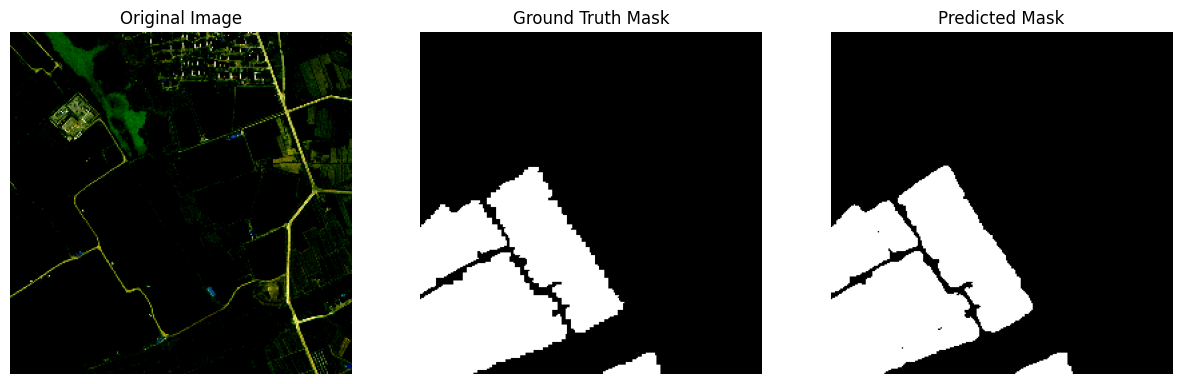

In [ ]:
def visualize_sample(val_dataset, model, idx=0):
    model.eval()

    # Load image and mask from validation dataset
    image, mask = val_dataset[idx]
    orig_image = np.moveaxis(image.numpy(), 0, -1)  # Convert (C, H, W) → (H, W, C)

    # Move image to GPU for inference
    image = image.unsqueeze(0).cuda()

    with torch.no_grad():
        output = model(image)  # Model output
        if isinstance(output, dict) and "logits" in output:
            output = output["logits"]  # If model returns logits dictionary

        pred_mask = torch.sigmoid(output).squeeze().cpu().numpy()  # Convert to probability map
        pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Convert to binary mask

    # Convert ground truth mask to NumPy array
    mask = mask.squeeze().cpu().numpy()

    # Plot the results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(orig_image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()

# Run visualization for a random validation sample
visualize_sample(val_dataset, model, idx=5)

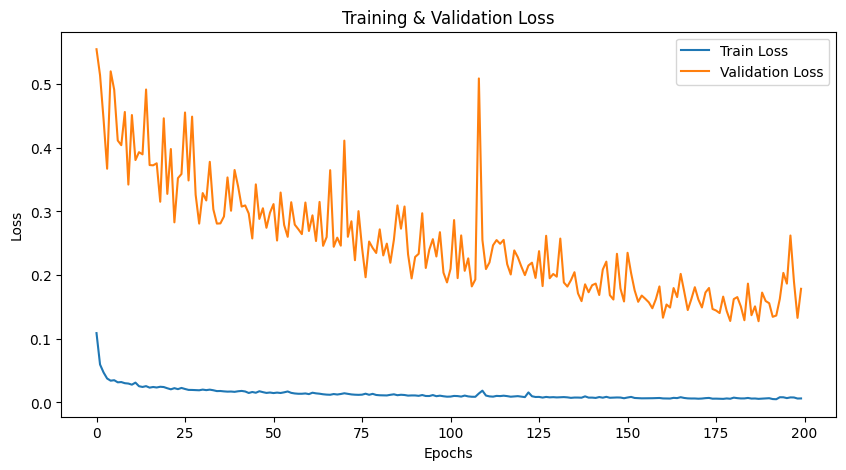

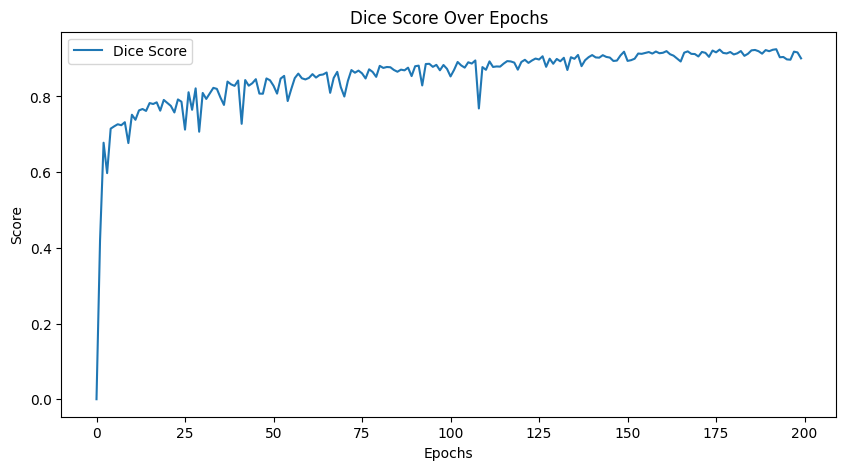

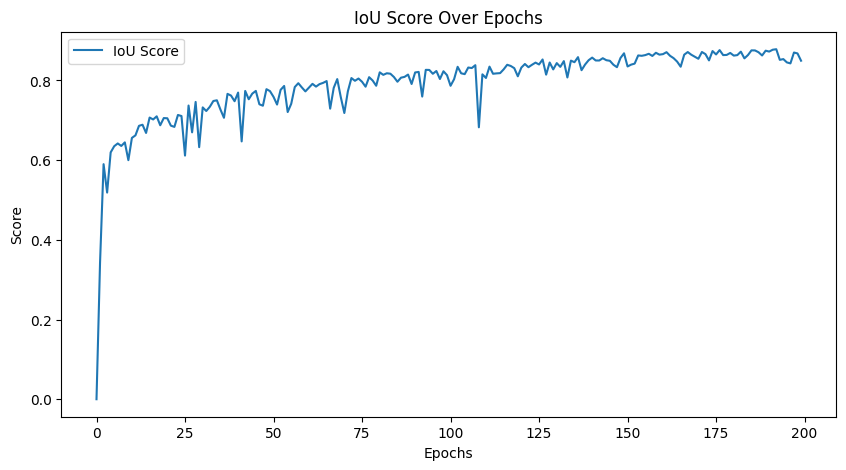

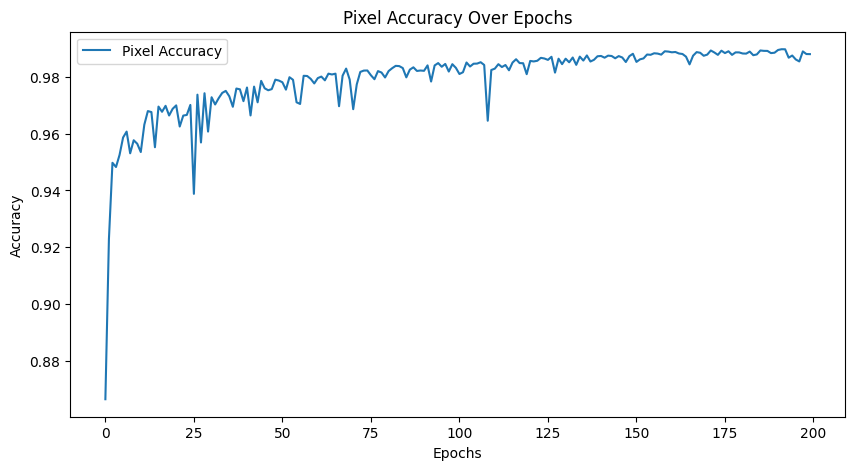

In [ ]:
# Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

# Plot Dice Score
plt.figure(figsize=(10, 5))
plt.plot(dice_scores, label="Dice Score")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("Dice Score Over Epochs")
plt.legend()
plt.show()

# Plot IoU Score
plt.figure(figsize=(10, 5))
plt.plot(iou_scores, label="IoU Score")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("IoU Score Over Epochs")
plt.legend()
plt.show()

# Plot Pixel Accuracy
plt.figure(figsize=(10, 5))
plt.plot(acc_scores, label="Pixel Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Pixel Accuracy Over Epochs")
plt.legend()
plt.show()


In [ ]:
# Save the trained model (recommended: save only state_dict)
torch.save(model.state_dict(), "attention_unet_98.pth")

print("✅ Model saved successfully!")

✅ Model saved successfully!


## Segformer + Unet

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from transformers import SegformerForSemanticSegmentation

In [ ]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define Transformations
# transform = A.Compose([
#     A.Resize(256, 256),  # Resize to SegFormer input size
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(p=0.2),
#     A.Normalize(mean=[0.5], std=[0.5]),
#     ToTensorV2()
# ])
transform = A.Compose([
    A.Resize(256, 256),  # Resize to SegFormer input size
    A.HorizontalFlip(p=0.5),  # Randomly flip horizontally
    A.VerticalFlip(p=0.2),  # Randomly flip vertically
    A.RandomBrightnessContrast(p=0.2),  # Adjust brightness and contrast
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=20, p=0.5),  # Small shifts, scaling, rotation
    A.GaussianBlur(blur_limit=(3, 5), p=0.2),  # Slight blurring for robustness
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),  # Add slight Gaussian noise
    A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.2),  # Slight grid distortion
    A.Normalize(mean=[0.5], std=[0.5]),  # Normalize
    ToTensorV2()  # Convert to tensor
])

# Custom Dataset Class
class SolarPanelDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace(".bmp", "_label.bmp"))

        # Load Image & Mask
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype("uint8")  # Convert to binary mask
        # Apply Transformations
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        return image, mask.unsqueeze(0)  # Add channel dimension

# Load Dataset
train_dataset = SolarPanelDataset("/content/dataset/train/images", "/content/dataset/train/labels", transform=transform)
val_dataset = SolarPanelDataset("/content/dataset/val/images", "/content/dataset/val/labels", transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

print(f"✅ Dataset Loaded: {len(train_dataset)} train, {len(val_dataset)} val samples")

✅ Dataset Loaded: 534 train, 152 val samples


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-20-b25af1bbd4bf>:23: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),  # Add slight Gaussian noise


In [ ]:
import torch
import torch.nn as nn
from transformers import SegformerForSemanticSegmentation

class SegFormerUNet(nn.Module):
    def __init__(self, model_name="nvidia/segformer-b2-finetuned-ade-512-512", num_classes=1):
        super(SegFormerUNet, self).__init__()

        # Load Pretrained SegFormer
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(model_name)

        # Extract Encoder
        self.encoder = self.segformer.segformer.encoder  # Correct way to get encoder

        # U-Net Style Decoder (Upsampling to match input size)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),  # 16x16 -> 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),  # 32x32 -> 64x64
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),   # 64x64 -> 128x128
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),    # 128x128 -> 256x256
            nn.ReLU(),
            nn.ConvTranspose2d(32, num_classes, kernel_size=2, stride=2)  # 256x256 -> 512x512
        )

    def forward(self, x):
        retained_input = x  # Keep input image

        # Encoder processing
        encoder_output = self.encoder(x)  # Extract encoder features
        encoder_output = encoder_output.last_hidden_state.permute(0, 1, 2, 3)  # (B, C, H, W)
        # print("Encoder Output Shape:", encoder_output.shape)  # Should be (B, 512, 16, 16)

        # Decoder (Upsample back to input size)
        output = self.decoder(encoder_output)  # (B, num_classes, 512, 512)

        return output  # Retain input & return segmentation mask

# Test Model with Random Input
sample_input = torch.randn(1, 3, 512, 512).cuda()
model = SegFormerUNet().cuda()
model.eval()

with torch.no_grad():
    output = model(sample_input)

print("Output Shape:", output.shape)  # (1, 1, 512, 512) ✅ Now matches input size


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/6.88k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/110M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/110M [00:00<?, ?B/s]

Output Shape: torch.Size([1, 1, 512, 512])


In [ ]:
def dice_score(preds, targets):
    smooth = 1e-6
    preds = (preds > 0.5).float()
    intersection = (preds * targets).sum()
    return (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)

def iou_score(preds, targets):
    smooth = 1e-6
    preds = (preds > 0.5).float()
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    return (intersection + smooth) / (union + smooth)

def pixel_accuracy(preds, targets):
    preds = (preds > 0.5).float()
    return (preds == targets).float().mean()


In [ ]:
# Loss Function: BCE + Dice Loss
class DiceBCELoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceBCELoss, self).__init__()
        self.smooth = smooth
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, preds, targets):
        bce_loss = self.bce(preds, targets)

        preds = torch.sigmoid(preds)
        intersection = (preds * targets).sum(dim=(2, 3))
        dice_loss = 1 - ((2. * intersection + self.smooth) / (preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3)) + self.smooth)).mean()

        return 0.5 * bce_loss + 0.5 * dice_loss

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super(FocalLoss, self).__init__()
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
        pt = torch.exp(-BCE)
        F_loss = (1 - pt) ** self.gamma * BCE
        return F_loss.mean()

In [ ]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SegFormerUNet().to(device)
scaler = GradScaler()  # Enable Mixed Precision

def train_model(model, train_loader, val_loader, optimizer, num_epochs=10, device="cuda"):
    model.to(device)

    # Lists to store metrics
    train_losses, val_losses = [], []
    dice_scores, iou_scores, acc_scores = [], [], []

    scaler = GradScaler()  # Enable Mixed Precision (AMP)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # Training Progress Bar
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

        for images, masks in train_loader_tqdm:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()

            # ✅ Enable AMP during forward pass
            with autocast():
                outputs = model(images)
                loss = DiceBCELoss()(outputs.float(), masks.float())  # Compute loss

            # ✅ Scale gradients for stable AMP training
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

        # Compute Training Loss
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Compute Validation Metrics
        model.eval()
        total_loss, total_dice, total_iou, total_acc = 0.0, 0.0, 0.0, 0.0
        num_samples = 0

        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)

                with autocast():  # Use AMP for validation too
                    outputs = model(images)
                loss = DiceBCELoss()(outputs.float(), masks.float())
                total_loss += loss.item()

                # Compute Validation Metrics
                total_dice += dice_score(outputs, masks)
                total_iou += iou_score(outputs, masks)
                total_acc += pixel_accuracy(outputs.float(), masks.float())

                num_samples += 1

        avg_val_loss = total_loss / num_samples
        avg_dice = total_dice / num_samples
        avg_iou = total_iou / num_samples
        avg_acc = total_acc / num_samples

        # Store validation metrics
        val_losses.append(avg_val_loss)
        dice_scores.append(avg_dice)
        iou_scores.append(avg_iou)
        acc_scores.append(avg_acc)

        print(f"✅ Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Dice: {avg_dice:.4f} | IoU: {avg_iou:.4f} | Acc: {avg_acc:.4f}")

    print("🎯 Training Complete!")

    # Return stored metrics
    return train_losses, val_losses, dice_scores, iou_scores, acc_scores

# Optimizer & Training
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
train_losses, val_losses, dice_scores, iou_scores, acc_scores = train_model(
    model, train_loader, val_loader, optimizer, num_epochs=200, device="cuda"
)


<ipython-input-105-5056e9d88e96>:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Enable Mixed Precision
<ipython-input-105-5056e9d88e96>:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Enable Mixed Precision (AMP)
Epoch 1/200:   0%|          | 0/67 [00:00<?, ?it/s]<ipython-input-105-5056e9d88e96>:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-105-5056e9d88e96>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Use AMP for validation too


✅ Epoch [1/200] | Train Loss: 0.7425 | Val Loss: 0.5337 | Dice: 0.0000 | IoU: 0.0000 | Acc: 0.8755


✅ Epoch [2/200] | Train Loss: 0.4241 | Val Loss: 0.3877 | Dice: 0.0000 | IoU: 0.0000 | Acc: 0.8755


✅ Epoch [3/200] | Train Loss: 0.3693 | Val Loss: 0.3435 | Dice: 0.6532 | IoU: 0.4960 | Acc: 0.9233


✅ Epoch [4/200] | Train Loss: 0.3291 | Val Loss: 0.2985 | Dice: 0.7082 | IoU: 0.5622 | Acc: 0.9297


✅ Epoch [5/200] | Train Loss: 0.2982 | Val Loss: 0.2889 | Dice: 0.7232 | IoU: 0.5829 | Acc: 0.9362


✅ Epoch [6/200] | Train Loss: 0.2692 | Val Loss: 0.2716 | Dice: 0.7357 | IoU: 0.5973 | Acc: 0.9461


✅ Epoch [7/200] | Train Loss: 0.2410 | Val Loss: 0.2650 | Dice: 0.7316 | IoU: 0.5944 | Acc: 0.9415


✅ Epoch [8/200] | Train Loss: 0.2331 | Val Loss: 0.2549 | Dice: 0.7485 | IoU: 0.6115 | Acc: 0.9494


✅ Epoch [9/200] | Train Loss: 0.2293 | Val Loss: 0.2473 | Dice: 0.7709 | IoU: 0.6410 | Acc: 0.9507


✅ Epoch [10/200] | Train Loss: 0.2316 | Val Loss: 0.2503 | Dice: 0.7724 | IoU: 0.6436 | Acc: 0.9492


✅ Epoch [11/200] | Train Loss: 0.2144 | Val Loss: 0.2366 | Dice: 0.7731 | IoU: 0.6464 | Acc: 0.9498


✅ Epoch [12/200] | Train Loss: 0.2231 | Val Loss: 0.2314 | Dice: 0.7723 | IoU: 0.6501 | Acc: 0.9549


✅ Epoch [13/200] | Train Loss: 0.2129 | Val Loss: 0.2371 | Dice: 0.7585 | IoU: 0.6270 | Acc: 0.9537


✅ Epoch [14/200] | Train Loss: 0.2052 | Val Loss: 0.2175 | Dice: 0.7749 | IoU: 0.6447 | Acc: 0.9529


✅ Epoch [15/200] | Train Loss: 0.2312 | Val Loss: 0.2421 | Dice: 0.7638 | IoU: 0.6339 | Acc: 0.9496


✅ Epoch [16/200] | Train Loss: 0.2062 | Val Loss: 0.2194 | Dice: 0.7812 | IoU: 0.6569 | Acc: 0.9526


✅ Epoch [17/200] | Train Loss: 0.1949 | Val Loss: 0.2228 | Dice: 0.7718 | IoU: 0.6495 | Acc: 0.9533


✅ Epoch [18/200] | Train Loss: 0.1861 | Val Loss: 0.2186 | Dice: 0.7801 | IoU: 0.6508 | Acc: 0.9487


✅ Epoch [19/200] | Train Loss: 0.2041 | Val Loss: 0.2217 | Dice: 0.7832 | IoU: 0.6577 | Acc: 0.9522


✅ Epoch [20/200] | Train Loss: 0.1932 | Val Loss: 0.2209 | Dice: 0.7751 | IoU: 0.6478 | Acc: 0.9552


✅ Epoch [21/200] | Train Loss: 0.1796 | Val Loss: 0.2137 | Dice: 0.7807 | IoU: 0.6621 | Acc: 0.9568


✅ Epoch [22/200] | Train Loss: 0.1896 | Val Loss: 0.1941 | Dice: 0.7908 | IoU: 0.6712 | Acc: 0.9577


✅ Epoch [23/200] | Train Loss: 0.1827 | Val Loss: 0.2033 | Dice: 0.7975 | IoU: 0.6770 | Acc: 0.9598


✅ Epoch [24/200] | Train Loss: 0.1844 | Val Loss: 0.2136 | Dice: 0.7680 | IoU: 0.6453 | Acc: 0.9576


✅ Epoch [25/200] | Train Loss: 0.1923 | Val Loss: 0.2080 | Dice: 0.7919 | IoU: 0.6720 | Acc: 0.9570


✅ Epoch [26/200] | Train Loss: 0.1865 | Val Loss: 0.2049 | Dice: 0.7882 | IoU: 0.6670 | Acc: 0.9589


✅ Epoch [27/200] | Train Loss: 0.1702 | Val Loss: 0.2122 | Dice: 0.7830 | IoU: 0.6635 | Acc: 0.9589


✅ Epoch [28/200] | Train Loss: 0.1932 | Val Loss: 0.1990 | Dice: 0.7963 | IoU: 0.6802 | Acc: 0.9592


✅ Epoch [29/200] | Train Loss: 0.1734 | Val Loss: 0.2217 | Dice: 0.7665 | IoU: 0.6452 | Acc: 0.9563


✅ Epoch [30/200] | Train Loss: 0.1734 | Val Loss: 0.2187 | Dice: 0.7925 | IoU: 0.6754 | Acc: 0.9578


✅ Epoch [31/200] | Train Loss: 0.1712 | Val Loss: 0.2000 | Dice: 0.8041 | IoU: 0.6880 | Acc: 0.9609


✅ Epoch [32/200] | Train Loss: 0.1821 | Val Loss: 0.2089 | Dice: 0.7779 | IoU: 0.6574 | Acc: 0.9564


✅ Epoch [33/200] | Train Loss: 0.1922 | Val Loss: 0.2026 | Dice: 0.8066 | IoU: 0.6882 | Acc: 0.9585


✅ Epoch [34/200] | Train Loss: 0.1742 | Val Loss: 0.1994 | Dice: 0.8051 | IoU: 0.6873 | Acc: 0.9601


✅ Epoch [35/200] | Train Loss: 0.1841 | Val Loss: 0.1958 | Dice: 0.8130 | IoU: 0.6932 | Acc: 0.9614


✅ Epoch [36/200] | Train Loss: 0.1714 | Val Loss: 0.2082 | Dice: 0.7723 | IoU: 0.6487 | Acc: 0.9574


✅ Epoch [37/200] | Train Loss: 0.1710 | Val Loss: 0.1968 | Dice: 0.7961 | IoU: 0.6804 | Acc: 0.9608


✅ Epoch [38/200] | Train Loss: 0.1727 | Val Loss: 0.1999 | Dice: 0.8080 | IoU: 0.6917 | Acc: 0.9622


✅ Epoch [39/200] | Train Loss: 0.1751 | Val Loss: 0.1931 | Dice: 0.8114 | IoU: 0.6984 | Acc: 0.9621


✅ Epoch [40/200] | Train Loss: 0.1806 | Val Loss: 0.2104 | Dice: 0.7917 | IoU: 0.6693 | Acc: 0.9595


✅ Epoch [41/200] | Train Loss: 0.1722 | Val Loss: 0.2035 | Dice: 0.8012 | IoU: 0.6843 | Acc: 0.9607


✅ Epoch [42/200] | Train Loss: 0.1683 | Val Loss: 0.2057 | Dice: 0.8032 | IoU: 0.6855 | Acc: 0.9600


✅ Epoch [43/200] | Train Loss: 0.1581 | Val Loss: 0.1991 | Dice: 0.8106 | IoU: 0.6990 | Acc: 0.9576


✅ Epoch [44/200] | Train Loss: 0.1525 | Val Loss: 0.1994 | Dice: 0.8078 | IoU: 0.6933 | Acc: 0.9591


✅ Epoch [45/200] | Train Loss: 0.1774 | Val Loss: 0.1903 | Dice: 0.8015 | IoU: 0.6845 | Acc: 0.9598


✅ Epoch [46/200] | Train Loss: 0.1679 | Val Loss: 0.2026 | Dice: 0.8153 | IoU: 0.7012 | Acc: 0.9619


✅ Epoch [47/200] | Train Loss: 0.1582 | Val Loss: 0.1889 | Dice: 0.8257 | IoU: 0.7160 | Acc: 0.9635


✅ Epoch [48/200] | Train Loss: 0.1702 | Val Loss: 0.2117 | Dice: 0.7749 | IoU: 0.6522 | Acc: 0.9558


✅ Epoch [49/200] | Train Loss: 0.1672 | Val Loss: 0.2149 | Dice: 0.7991 | IoU: 0.6810 | Acc: 0.9605


✅ Epoch [50/200] | Train Loss: 0.1797 | Val Loss: 0.2166 | Dice: 0.7868 | IoU: 0.6646 | Acc: 0.9584


✅ Epoch [51/200] | Train Loss: 0.1715 | Val Loss: 0.2022 | Dice: 0.8133 | IoU: 0.6989 | Acc: 0.9602


✅ Epoch [52/200] | Train Loss: 0.1744 | Val Loss: 0.2009 | Dice: 0.8303 | IoU: 0.7202 | Acc: 0.9637


✅ Epoch [53/200] | Train Loss: 0.1674 | Val Loss: 0.1990 | Dice: 0.8034 | IoU: 0.6861 | Acc: 0.9607


✅ Epoch [54/200] | Train Loss: 0.1592 | Val Loss: 0.1872 | Dice: 0.8179 | IoU: 0.7087 | Acc: 0.9633


✅ Epoch [55/200] | Train Loss: 0.1608 | Val Loss: 0.1969 | Dice: 0.7909 | IoU: 0.6756 | Acc: 0.9598


✅ Epoch [56/200] | Train Loss: 0.1625 | Val Loss: 0.2041 | Dice: 0.8121 | IoU: 0.6976 | Acc: 0.9594


✅ Epoch [57/200] | Train Loss: 0.1697 | Val Loss: 0.1843 | Dice: 0.8273 | IoU: 0.7172 | Acc: 0.9625


✅ Epoch [58/200] | Train Loss: 0.1507 | Val Loss: 0.1853 | Dice: 0.8249 | IoU: 0.7195 | Acc: 0.9648


✅ Epoch [59/200] | Train Loss: 0.1634 | Val Loss: 0.1834 | Dice: 0.8133 | IoU: 0.6991 | Acc: 0.9569


✅ Epoch [60/200] | Train Loss: 0.1632 | Val Loss: 0.2023 | Dice: 0.8117 | IoU: 0.6957 | Acc: 0.9600


✅ Epoch [61/200] | Train Loss: 0.1552 | Val Loss: 0.1978 | Dice: 0.8140 | IoU: 0.6983 | Acc: 0.9608


✅ Epoch [62/200] | Train Loss: 0.1532 | Val Loss: 0.1946 | Dice: 0.8205 | IoU: 0.7120 | Acc: 0.9650


✅ Epoch [63/200] | Train Loss: 0.1470 | Val Loss: 0.1950 | Dice: 0.8136 | IoU: 0.7015 | Acc: 0.9631


✅ Epoch [64/200] | Train Loss: 0.1485 | Val Loss: 0.1884 | Dice: 0.8191 | IoU: 0.7059 | Acc: 0.9638


✅ Epoch [65/200] | Train Loss: 0.1525 | Val Loss: 0.1931 | Dice: 0.8145 | IoU: 0.7009 | Acc: 0.9575


✅ Epoch [66/200] | Train Loss: 0.1503 | Val Loss: 0.1776 | Dice: 0.8297 | IoU: 0.7231 | Acc: 0.9658


✅ Epoch [67/200] | Train Loss: 0.1362 | Val Loss: 0.1798 | Dice: 0.8221 | IoU: 0.7165 | Acc: 0.9651


✅ Epoch [68/200] | Train Loss: 0.1421 | Val Loss: 0.2057 | Dice: 0.8155 | IoU: 0.7070 | Acc: 0.9640


✅ Epoch [69/200] | Train Loss: 0.1849 | Val Loss: 0.2007 | Dice: 0.8072 | IoU: 0.6916 | Acc: 0.9614


✅ Epoch [70/200] | Train Loss: 0.1761 | Val Loss: 0.1935 | Dice: 0.8028 | IoU: 0.6883 | Acc: 0.9611


✅ Epoch [71/200] | Train Loss: 0.1541 | Val Loss: 0.1844 | Dice: 0.8219 | IoU: 0.7101 | Acc: 0.9622


✅ Epoch [72/200] | Train Loss: 0.1482 | Val Loss: 0.1797 | Dice: 0.8296 | IoU: 0.7220 | Acc: 0.9665


✅ Epoch [73/200] | Train Loss: 0.1500 | Val Loss: 0.1820 | Dice: 0.8322 | IoU: 0.7235 | Acc: 0.9662


✅ Epoch [74/200] | Train Loss: 0.1494 | Val Loss: 0.2013 | Dice: 0.8243 | IoU: 0.7081 | Acc: 0.9623


✅ Epoch [75/200] | Train Loss: 0.1513 | Val Loss: 0.1754 | Dice: 0.8417 | IoU: 0.7378 | Acc: 0.9672


✅ Epoch [76/200] | Train Loss: 0.1606 | Val Loss: 0.2177 | Dice: 0.7961 | IoU: 0.6783 | Acc: 0.9600


✅ Epoch [77/200] | Train Loss: 0.1489 | Val Loss: 0.2112 | Dice: 0.8008 | IoU: 0.6827 | Acc: 0.9574


✅ Epoch [78/200] | Train Loss: 0.1383 | Val Loss: 0.1887 | Dice: 0.8343 | IoU: 0.7268 | Acc: 0.9659


✅ Epoch [79/200] | Train Loss: 0.1374 | Val Loss: 0.1720 | Dice: 0.8402 | IoU: 0.7356 | Acc: 0.9667


✅ Epoch [80/200] | Train Loss: 0.1440 | Val Loss: 0.1825 | Dice: 0.8363 | IoU: 0.7319 | Acc: 0.9641


✅ Epoch [81/200] | Train Loss: 0.1381 | Val Loss: 0.1694 | Dice: 0.8395 | IoU: 0.7354 | Acc: 0.9669


✅ Epoch [82/200] | Train Loss: 0.1408 | Val Loss: 0.1896 | Dice: 0.8154 | IoU: 0.7073 | Acc: 0.9617


✅ Epoch [83/200] | Train Loss: 0.1587 | Val Loss: 0.1660 | Dice: 0.8363 | IoU: 0.7272 | Acc: 0.9671


✅ Epoch [84/200] | Train Loss: 0.1550 | Val Loss: 0.1811 | Dice: 0.8296 | IoU: 0.7225 | Acc: 0.9655


✅ Epoch [85/200] | Train Loss: 0.1325 | Val Loss: 0.1978 | Dice: 0.8155 | IoU: 0.7085 | Acc: 0.9635


✅ Epoch [86/200] | Train Loss: 0.1428 | Val Loss: 0.1694 | Dice: 0.8328 | IoU: 0.7286 | Acc: 0.9665


✅ Epoch [87/200] | Train Loss: 0.1345 | Val Loss: 0.1735 | Dice: 0.8261 | IoU: 0.7157 | Acc: 0.9651


✅ Epoch [88/200] | Train Loss: 0.1320 | Val Loss: 0.1750 | Dice: 0.8294 | IoU: 0.7213 | Acc: 0.9653


✅ Epoch [89/200] | Train Loss: 0.1405 | Val Loss: 0.1851 | Dice: 0.8265 | IoU: 0.7174 | Acc: 0.9659


✅ Epoch [90/200] | Train Loss: 0.1446 | Val Loss: 0.1721 | Dice: 0.8394 | IoU: 0.7346 | Acc: 0.9658


✅ Epoch [91/200] | Train Loss: 0.1350 | Val Loss: 0.1723 | Dice: 0.8407 | IoU: 0.7364 | Acc: 0.9674


✅ Epoch [92/200] | Train Loss: 0.1334 | Val Loss: 0.1741 | Dice: 0.8286 | IoU: 0.7238 | Acc: 0.9675


✅ Epoch [93/200] | Train Loss: 0.1528 | Val Loss: 0.1914 | Dice: 0.8055 | IoU: 0.6929 | Acc: 0.9555


✅ Epoch [94/200] | Train Loss: 0.1593 | Val Loss: 0.1821 | Dice: 0.8295 | IoU: 0.7237 | Acc: 0.9660


✅ Epoch [95/200] | Train Loss: 0.1464 | Val Loss: 0.1913 | Dice: 0.8246 | IoU: 0.7143 | Acc: 0.9647


✅ Epoch [96/200] | Train Loss: 0.1410 | Val Loss: 0.1780 | Dice: 0.8290 | IoU: 0.7250 | Acc: 0.9667


✅ Epoch [97/200] | Train Loss: 0.1471 | Val Loss: 0.2301 | Dice: 0.7845 | IoU: 0.6638 | Acc: 0.9470


✅ Epoch [98/200] | Train Loss: 0.1484 | Val Loss: 0.1796 | Dice: 0.8322 | IoU: 0.7247 | Acc: 0.9659


✅ Epoch [99/200] | Train Loss: 0.1349 | Val Loss: 0.2019 | Dice: 0.8091 | IoU: 0.6958 | Acc: 0.9626


✅ Epoch [100/200] | Train Loss: 0.1362 | Val Loss: 0.1696 | Dice: 0.8466 | IoU: 0.7437 | Acc: 0.9675


✅ Epoch [101/200] | Train Loss: 0.1301 | Val Loss: 0.1967 | Dice: 0.8035 | IoU: 0.6890 | Acc: 0.9616


✅ Epoch [102/200] | Train Loss: 0.1358 | Val Loss: 0.1742 | Dice: 0.8365 | IoU: 0.7350 | Acc: 0.9692


✅ Epoch [103/200] | Train Loss: 0.1326 | Val Loss: 0.1711 | Dice: 0.8232 | IoU: 0.7227 | Acc: 0.9678


✅ Epoch [104/200] | Train Loss: 0.1462 | Val Loss: 0.1848 | Dice: 0.8318 | IoU: 0.7247 | Acc: 0.9658


✅ Epoch [105/200] | Train Loss: 0.1331 | Val Loss: 0.1790 | Dice: 0.8419 | IoU: 0.7378 | Acc: 0.9678


✅ Epoch [106/200] | Train Loss: 0.1340 | Val Loss: 0.1779 | Dice: 0.8328 | IoU: 0.7237 | Acc: 0.9671


✅ Epoch [107/200] | Train Loss: 0.1389 | Val Loss: 0.1667 | Dice: 0.8394 | IoU: 0.7362 | Acc: 0.9676


✅ Epoch [108/200] | Train Loss: 0.1371 | Val Loss: 0.1942 | Dice: 0.8254 | IoU: 0.7158 | Acc: 0.9663


✅ Epoch [109/200] | Train Loss: 0.1280 | Val Loss: 0.1816 | Dice: 0.8377 | IoU: 0.7311 | Acc: 0.9674


✅ Epoch [110/200] | Train Loss: 0.1287 | Val Loss: 0.1641 | Dice: 0.8491 | IoU: 0.7509 | Acc: 0.9699


✅ Epoch [111/200] | Train Loss: 0.1344 | Val Loss: 0.1683 | Dice: 0.8443 | IoU: 0.7423 | Acc: 0.9685


✅ Epoch [112/200] | Train Loss: 0.1387 | Val Loss: 0.1942 | Dice: 0.8322 | IoU: 0.7294 | Acc: 0.9649


✅ Epoch [113/200] | Train Loss: 0.1396 | Val Loss: 0.1795 | Dice: 0.8291 | IoU: 0.7247 | Acc: 0.9648


✅ Epoch [114/200] | Train Loss: 0.1254 | Val Loss: 0.1940 | Dice: 0.7989 | IoU: 0.6825 | Acc: 0.9585


✅ Epoch [115/200] | Train Loss: 0.1639 | Val Loss: 0.1879 | Dice: 0.8225 | IoU: 0.7112 | Acc: 0.9626


✅ Epoch [116/200] | Train Loss: 0.1517 | Val Loss: 0.2008 | Dice: 0.8183 | IoU: 0.7053 | Acc: 0.9609


✅ Epoch [117/200] | Train Loss: 0.1559 | Val Loss: 0.1811 | Dice: 0.8306 | IoU: 0.7294 | Acc: 0.9647


✅ Epoch [118/200] | Train Loss: 0.1861 | Val Loss: 0.2186 | Dice: 0.7699 | IoU: 0.6510 | Acc: 0.9558


✅ Epoch [119/200] | Train Loss: 0.1642 | Val Loss: 0.1994 | Dice: 0.8175 | IoU: 0.7050 | Acc: 0.9634


✅ Epoch [120/200] | Train Loss: 0.1483 | Val Loss: 0.1776 | Dice: 0.8212 | IoU: 0.7162 | Acc: 0.9652


✅ Epoch [121/200] | Train Loss: 0.1427 | Val Loss: 0.1820 | Dice: 0.8204 | IoU: 0.7124 | Acc: 0.9659


✅ Epoch [122/200] | Train Loss: 0.1429 | Val Loss: 0.1906 | Dice: 0.8105 | IoU: 0.7007 | Acc: 0.9625


✅ Epoch [123/200] | Train Loss: 0.1414 | Val Loss: 0.1844 | Dice: 0.8241 | IoU: 0.7162 | Acc: 0.9640


✅ Epoch [124/200] | Train Loss: 0.1514 | Val Loss: 0.1928 | Dice: 0.8109 | IoU: 0.6980 | Acc: 0.9616


✅ Epoch [125/200] | Train Loss: 0.1489 | Val Loss: 0.1865 | Dice: 0.8337 | IoU: 0.7305 | Acc: 0.9674


✅ Epoch [126/200] | Train Loss: 0.1474 | Val Loss: 0.1765 | Dice: 0.8347 | IoU: 0.7308 | Acc: 0.9639


✅ Epoch [127/200] | Train Loss: 0.1290 | Val Loss: 0.1656 | Dice: 0.8391 | IoU: 0.7372 | Acc: 0.9668


✅ Epoch [128/200] | Train Loss: 0.1409 | Val Loss: 0.1745 | Dice: 0.8365 | IoU: 0.7347 | Acc: 0.9667


✅ Epoch [129/200] | Train Loss: 0.1260 | Val Loss: 0.1918 | Dice: 0.8235 | IoU: 0.7140 | Acc: 0.9637


✅ Epoch [130/200] | Train Loss: 0.1351 | Val Loss: 0.1830 | Dice: 0.8330 | IoU: 0.7311 | Acc: 0.9663


✅ Epoch [131/200] | Train Loss: 0.1373 | Val Loss: 0.1737 | Dice: 0.8320 | IoU: 0.7272 | Acc: 0.9659


✅ Epoch [132/200] | Train Loss: 0.1341 | Val Loss: 0.1991 | Dice: 0.8139 | IoU: 0.7057 | Acc: 0.9657


✅ Epoch [133/200] | Train Loss: 0.1277 | Val Loss: 0.1931 | Dice: 0.8146 | IoU: 0.7059 | Acc: 0.9654


✅ Epoch [134/200] | Train Loss: 0.1207 | Val Loss: 0.1758 | Dice: 0.8415 | IoU: 0.7418 | Acc: 0.9677


✅ Epoch [135/200] | Train Loss: 0.1287 | Val Loss: 0.1751 | Dice: 0.8399 | IoU: 0.7334 | Acc: 0.9678


✅ Epoch [136/200] | Train Loss: 0.1250 | Val Loss: 0.1900 | Dice: 0.8260 | IoU: 0.7176 | Acc: 0.9650


✅ Epoch [137/200] | Train Loss: 0.1280 | Val Loss: 0.1828 | Dice: 0.8288 | IoU: 0.7212 | Acc: 0.9636


✅ Epoch [138/200] | Train Loss: 0.1229 | Val Loss: 0.1819 | Dice: 0.8188 | IoU: 0.7094 | Acc: 0.9624


✅ Epoch [139/200] | Train Loss: 0.1264 | Val Loss: 0.1958 | Dice: 0.8223 | IoU: 0.7147 | Acc: 0.9645


✅ Epoch [140/200] | Train Loss: 0.1263 | Val Loss: 0.1885 | Dice: 0.8181 | IoU: 0.7125 | Acc: 0.9622


✅ Epoch [141/200] | Train Loss: 0.1338 | Val Loss: 0.1726 | Dice: 0.8266 | IoU: 0.7189 | Acc: 0.9667


✅ Epoch [142/200] | Train Loss: 0.1286 | Val Loss: 0.1963 | Dice: 0.8107 | IoU: 0.7021 | Acc: 0.9626


✅ Epoch [143/200] | Train Loss: 0.1260 | Val Loss: 0.1878 | Dice: 0.8125 | IoU: 0.7120 | Acc: 0.9683


✅ Epoch [144/200] | Train Loss: 0.1271 | Val Loss: 0.1823 | Dice: 0.8306 | IoU: 0.7274 | Acc: 0.9673


✅ Epoch [145/200] | Train Loss: 0.1324 | Val Loss: 0.1691 | Dice: 0.8443 | IoU: 0.7445 | Acc: 0.9691


✅ Epoch [146/200] | Train Loss: 0.1276 | Val Loss: 0.1944 | Dice: 0.8153 | IoU: 0.7087 | Acc: 0.9638


✅ Epoch [147/200] | Train Loss: 0.1317 | Val Loss: 0.1990 | Dice: 0.8004 | IoU: 0.6898 | Acc: 0.9621


✅ Epoch [148/200] | Train Loss: 0.1222 | Val Loss: 0.1642 | Dice: 0.8440 | IoU: 0.7425 | Acc: 0.9692


✅ Epoch [149/200] | Train Loss: 0.1239 | Val Loss: 0.1829 | Dice: 0.8293 | IoU: 0.7249 | Acc: 0.9660


✅ Epoch [150/200] | Train Loss: 0.1152 | Val Loss: 0.1764 | Dice: 0.8395 | IoU: 0.7370 | Acc: 0.9683


✅ Epoch [151/200] | Train Loss: 0.1244 | Val Loss: 0.1713 | Dice: 0.8364 | IoU: 0.7331 | Acc: 0.9666


✅ Epoch [152/200] | Train Loss: 0.1286 | Val Loss: 0.1866 | Dice: 0.8267 | IoU: 0.7196 | Acc: 0.9655


✅ Epoch [153/200] | Train Loss: 0.1627 | Val Loss: 0.1989 | Dice: 0.8269 | IoU: 0.7226 | Acc: 0.9655


✅ Epoch [154/200] | Train Loss: 0.1447 | Val Loss: 0.1791 | Dice: 0.8316 | IoU: 0.7247 | Acc: 0.9666


✅ Epoch [155/200] | Train Loss: 0.1341 | Val Loss: 0.1676 | Dice: 0.8517 | IoU: 0.7518 | Acc: 0.9699


✅ Epoch [156/200] | Train Loss: 0.1334 | Val Loss: 0.1685 | Dice: 0.8502 | IoU: 0.7513 | Acc: 0.9702


✅ Epoch [157/200] | Train Loss: 0.1750 | Val Loss: 0.1709 | Dice: 0.8422 | IoU: 0.7398 | Acc: 0.9674


✅ Epoch [158/200] | Train Loss: 0.1442 | Val Loss: 0.1952 | Dice: 0.7938 | IoU: 0.6799 | Acc: 0.9600


✅ Epoch [159/200] | Train Loss: 0.1431 | Val Loss: 0.1953 | Dice: 0.8129 | IoU: 0.7014 | Acc: 0.9653


✅ Epoch [160/200] | Train Loss: 0.1322 | Val Loss: 0.1969 | Dice: 0.8253 | IoU: 0.7200 | Acc: 0.9661


Epoch 161/200:  76%|███████▌  | 51/67 [00:07<00:02,  7.00it/s]

In [ ]:
val_transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

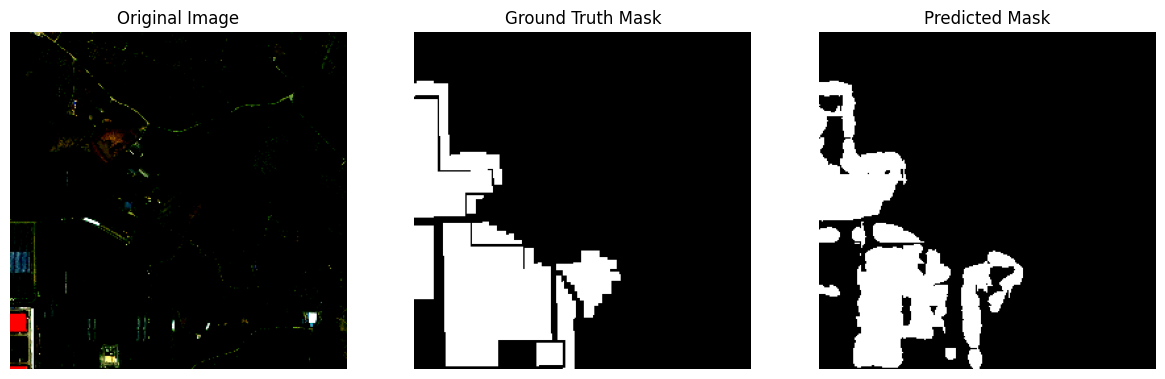

In [ ]:
def visualize_segformer_unet(val_dataset, model, idx=0):
    model.eval()

    # Load image and mask
    image, mask = val_dataset[idx]
    orig_image = np.moveaxis(image.numpy(), 0, -1)  # Convert (C, H, W) → (H, W, C)

    # Move image to GPU
    image = image.unsqueeze(0).cuda()

    with torch.no_grad():
        output = model(image)  # Retain input and get prediction

        pred_mask = torch.sigmoid(output).squeeze().cpu().numpy()
        pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Convert to binary mask

    # Convert ground truth mask to NumPy
    mask = mask.squeeze().cpu().numpy()

    # Plot all images
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(orig_image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()

# Run visualization
visualize_segformer_unet(val_dataset, model, idx=23)

In [ ]:
# for i in range(len(dice_scores)):
#   dice_scores[i] = dice_scores[i].cpu().item()
# for i in range(len(iou_scores)):
#   iou_scores[i] = iou_scores[i].cpu().item()
# for i in range(len(acc_scores)):
#   acc_scores[i] = acc_scores[i].cpu().item()

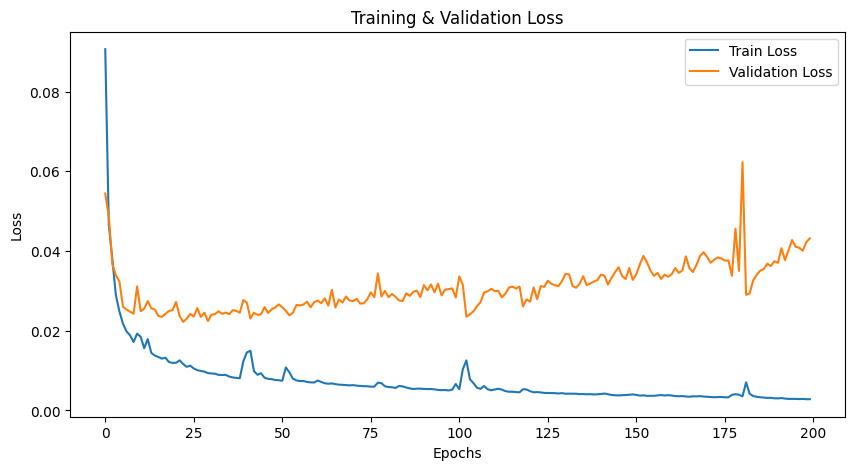

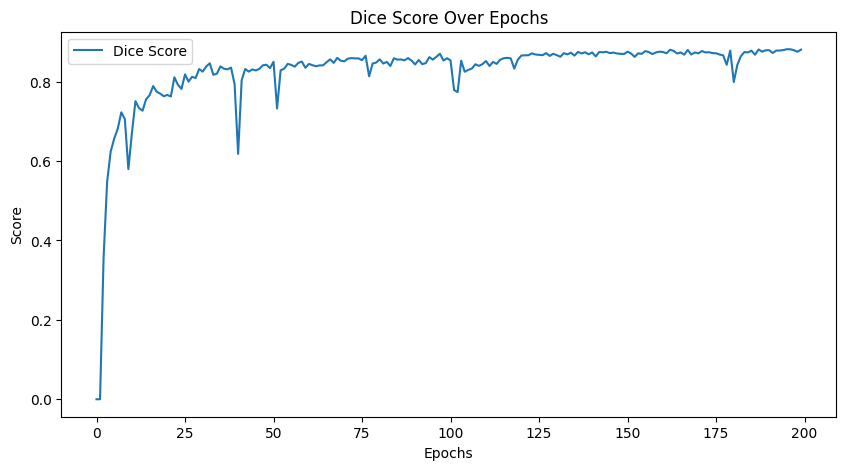

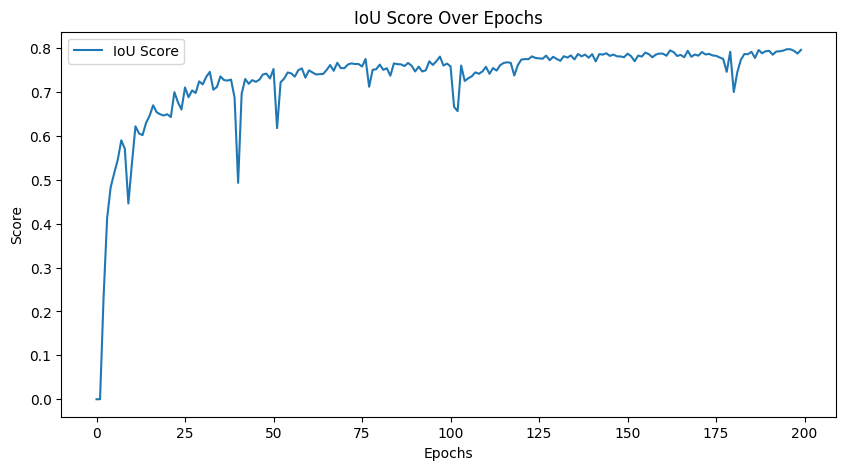

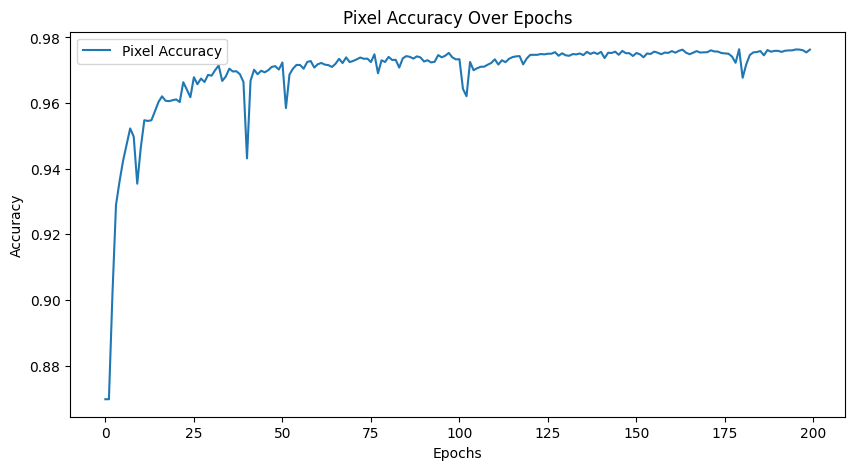

In [ ]:
# Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

# Plot Dice Score
plt.figure(figsize=(10, 5))
plt.plot(dice_scores, label="Dice Score")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("Dice Score Over Epochs")
plt.legend()
plt.show()

# Plot IoU Score
plt.figure(figsize=(10, 5))
plt.plot(iou_scores, label="IoU Score")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("IoU Score Over Epochs")
plt.legend()
plt.show()

# Plot Pixel Accuracy
plt.figure(figsize=(10, 5))
plt.plot(acc_scores, label="Pixel Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Pixel Accuracy Over Epochs")
plt.legend()
plt.show()


In [ ]:
# Save the trained model (recommended: save only state_dict)
torch.save(model.state_dict(), "segformer_unet_focal_loss_97_63.pth")

print("✅ Model saved successfully!")

✅ Model saved successfully!


# Free Memory

In [ ]:
!nvidia-smi

Sat Mar  8 09:54:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P0             26W /   70W |     136MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import torch

torch.cuda.empty_cache()

In [ ]:
import gc

del  model, train_loader, val_loader, test_loader, optimizer,train_losses, val_losses, dice_scores, iou_scores

gc.collect()
torch.cuda.empty_cache()

# Packaging the Code

In [ ]:
import torch
PATH = '/content/segformer-b0-finetuned-ade-512-512.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# this is for efficientnet-b7
# model_ = smp.Unet(
#     encoder_name="efficientnet-b7",
#     encoder_weights=None,
#     in_channels=3,
#     classes=1,
#     activation=None
# ).cuda()
# model_.load_state_dict(torch.load(PATH))

from transformers import SegformerForSemanticSegmentation
import torch

# Load model architecture
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=1,  # Binary segmentation
    ignore_mismatched_sizes=True
).cuda()

state_dict = torch.load(PATH, map_location="cuda")
model.load_state_dict(state_dict)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([1]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([1, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-83-8e810ec2a9f9>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default

<All keys matched successfully>

In [ ]:
def compute_solar_area(mask, PTM=0.125, OPTA=34):
    """
    Compute solar panel area from a binary segmentation mask.
    """
    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().detach().numpy()  # Convert to NumPy if Tensor
    if mask.ndim == 3:
        mask = mask.squeeze(0)  # Remove extra channel

    mask = (mask > 0.5).astype(np.float32)  # Ensure binary mask
    panel_pixels = mask.sum()  # Count solar panel pixels
    area_m2 = (panel_pixels * (PTM ** 2)) / np.cos(np.radians(OPTA))  # Convert to m²
    return area_m2

def compute_accuracy_metrics(segmented_mask, actual_mask, PTM=0.125):
    """
    Compute accuracy of segmented area vs. actual area using MAPE and IoU.
    """
    # Compute solar panel areas
    segmented_area = compute_solar_area(segmented_mask, PTM)
    actual_area = compute_solar_area(actual_mask, PTM)

    # Compute Mean Absolute Percentage Error (MAPE)
    mape_error = np.abs((segmented_area - actual_area) / actual_area) * 100 if actual_area != 0 else 0

    # Compute Intersection over Union (IoU)
    intersection = ((segmented_mask > 0.5) & (actual_mask > 0.5)).sum()
    union = ((segmented_mask > 0.5) | (actual_mask > 0.5)).sum()
    iou_score = intersection / union if union != 0 else 0

    return {
        "Segmented Area (m²)": segmented_area,
        "Actual Area (m²)": actual_area,
        "MAPE (%)": mape_error,
        "IoU Score": iou_score
    }


def compute_energy_output(area_m2, efficiency=0.19, GTI=1676.2, PR=0.935):
    """
    Compute estimated solar energy output.
    """
    return area_m2 * efficiency * GTI * PR

### Inferencing Efficientnet-b7

In [ ]:
# # this is for efficientnet-b7
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATH = "/content/unet_efficientdet-b7_imagenet.pth"
model_ = smp.Unet(
    encoder_name="efficientnet-b7",
    encoder_weights=None,
    in_channels=3,
    classes=1,
    activation=None
).cuda()
# model_.load_state_dict(torch.load(PATH))
img, mask = train_dataset.__getitem__(10)

model_.eval()
with torch.no_grad():
  pred_mask = model_(torch.tensor(img).unsqueeze(0).to(device))

NameError: name 'smp' is not defined

In [ ]:
def visualize_predictions(img,pred_mask,mask):
    model.eval()
    c = 0
    images, masks = val_dataset[idx]
    with torch.no_grad():
      images, masks = images.to(device), masks.to(device)
      outputs = model(images.unsqueeze(0))  # Forward pass
      preds = torch.sigmoid(outputs)  # Apply Sigmoid
      preds = (preds > 0.5).float()  # Threshold to binary

      # Convert to NumPy for visualization
      print(images.shape)
      image_np = images[0].cpu().permute(1, 2, 0).numpy()
      mask_np = masks[0].cpu().numpy()
      pred_np = preds[0].cpu().squeeze().numpy()
      pred_np[pred_np<=0] = 0

      # Plot original, ground truth, and prediction
      fig, ax = plt.subplots(1, 3, figsize=(15, 5))
      ax[0].imshow(image_np)
      ax[0].set_title("Original Image")
      ax[0].axis("off")

      ax[1].imshow(mask_np, cmap="gray")
      ax[1].set_title("Ground Truth Mask")
      ax[1].axis("off")

      ax[2].imshow(pred_np, cmap="gray")
      ax[2].set_title("Predicted Mask")
      ax[2].axis("off")

      plt.show()

# Visualize predictions
visualize_predictions(model_, val_dataset,idx=1)

In [ ]:
area = compute_solar_area(mask)

# Compute area in m²
area_m2 = compute_solar_area(mask)
print("ORIGINAL MASK ENERGY OUTPUT")
print(f"Estimated Solar Panel Area: {area_m2:.2f} m²")

# Compute energy output in kWh
energy_kwh = compute_energy_output(area_m2)
print(f"Estimated Energy Output: {(energy_kwh/1000):.2f} MWh per year")
plt.imshow(mask[0])

In [ ]:
area = compute_solar_area(pred_mask)

# Compute area in m²
area_m2 = compute_solar_area(pred_mask)
print("PREDICTED MASK ENERGY OUTPUT")
print(f"Estimated Solar Panel Area: {area_m2:.2f} m²")

# Compute energy output in kWh
energy_kwh = compute_energy_output(area_m2)
print(f"Estimated Energy Output: {(energy_kwh/1000):.2f} MWh per year")
pred_ = pred_mask[0][0].cpu().numpy()
pred_ = (pred_ > 0.5).astype(np.uint8)
plt.imshow(pred_)
# plt.imshow()

### Segformer

In [ ]:
from transformers import SegformerForSemanticSegmentation
import torch

model = SegFormerUNet().cuda()
checkpoint_path = "/content/drive/MyDrive/solar_panel_detection/models/segformer_unet_focal_loss_97_63.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)

# Load model state dict
model.load_state_dict(checkpoint)

print("Model weights loaded successfully!")

Model weights loaded successfully!


Number of different pixels: 501
--------------------
ORIGINAL MASK ENERGY OUTPUT
Estimated Solar Panel Area: 55.35 m²
Estimated Energy Output: 16.48 MWh per year
--------------------
--------------------
PREDICTED MASK ENERGY OUTPUT
Estimated Solar Panel Area: 57.11 m²
Estimated Energy Output: 17.01 MWh per year
--------------------


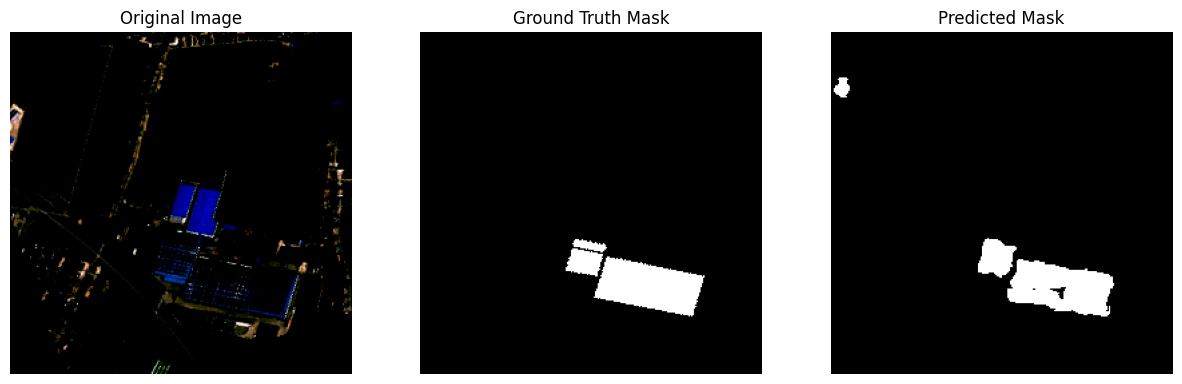

In [ ]:

def Calculate_solar_energy(val_dataset, model, idx=0):
    model.eval()

    # Load image and mask from validation set
    image, mask = val_dataset[idx]
    orig_image = np.moveaxis(image.numpy(), 0, -1)  # Convert from (C, H, W) to (H, W, C)

    # Move image to GPU
    image = image.unsqueeze(0).cuda()

    with torch.no_grad():
        output = model(image)  # Get raw logits
        pred_mask = torch.sigmoid(output).squeeze().cpu().numpy()  # Convert logits to probabilities
        pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Convert to binary mask

    # Resize ground truth mask for plotting
    mask = mask.squeeze().numpy()

    difference = np.sum(mask != pred_mask)
    print(f"Number of different pixels: {difference}")

    print("-"*20)
    # Compute area in m²
    area_m2 = compute_solar_area(mask)
    print("ORIGINAL MASK ENERGY OUTPUT")
    print(f"Estimated Solar Panel Area: {area_m2:.2f} m²")

    # Compute energy output in kWh
    energy_kwh = compute_energy_output(area_m2)
    print(f"Estimated Energy Output: {(energy_kwh/1000):.2f} MWh per year")
    print("-"*20)

    print("-"*20)
    # Compute area in m²
    area_m2 = compute_solar_area(pred_mask)
    print("PREDICTED MASK ENERGY OUTPUT")
    print(f"Estimated Solar Panel Area: {area_m2:.2f} m²")

    # Compute energy output in kWh
    energy_kwh = compute_energy_output(area_m2)
    print(f"Estimated Energy Output: {(energy_kwh/1000):.2f} MWh per year")
    print("-"*20)

    # Plot the results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(orig_image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()

# Run visualization for a random validation sample
Calculate_solar_energy(val_dataset, model, idx=21)

In [ ]:
import shutil
shutil.make_archive('/content/dataset/val_zip', 'zip', '/content/dataset/val')

'/content/dataset/val_zip.zip'